In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
print(torch.__version__)

2.1.0


# Part I - Environment Setup

We create the respective environment with all the necessary packages on my local machine

__conda activate ML_Learning2Add_Sevi__

# Part II - Reconstruction Autoencoder

We will start by designing an autoencoder that learns to reconstruct the images of the numbers.
For that, you will design the base encoder and decoder models:

In [149]:
# import libraries
import torch.nn.functional as F
import os
import random
import numpy as np
import torch
import cv2 as cv
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from collections import Counter
from itertools import islice

In [150]:
# Establecer la semilla
def set_seed(seed_value=42):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
set_seed(42)

Primera version 

__1. Implement the encoder, as seen during the class, with the following specs:__

• Conv (32, 3x3) padding = ‘same’, ReLU , (Max-Pooling 2, stride 2)

• Conv (64, 3x3) padding = ‘same’, ReLU , (Max-Pooling 2, stride 2)

• Conv (128, 3x3) padding = ‘same’, ReLU , (Max-Pooling 2, stride 2) 

• MLP (256), Linear

• MLP (2), Linear

###### Implementación del Encoder

In [408]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(in_features=128 * 3 * 3, out_features=256)
        #self.fc2 = nn.Linear(in_features=256, out_features=2)
        self.fc2 = nn.Linear(in_features=256, out_features=7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

__2. Implement three possible versions of the decoder varying operations (as discussed during the class):__
    
• Exact feature mirror model from the encoder (including the reserve of max-pooling).

• Using convolutions, activations, and upsampling.

• Reshaping the input images to a 64 × 64 image and using upsampling.

###### Implementación del Decoder

In [409]:
class DecoderConvTranspose(nn.Module):
    def __init__(self):
        super(DecoderConvTranspose, self).__init__()
        #self.fc1 = nn.Linear(2, 256)
        self.fc1 = nn.Linear(7, 256)
        self.fc2 = nn.Linear(256, 128 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # Tamaño después: 14x14
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # Tamaño después: 28x28
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

In [119]:
class DecoderConvUpsample(nn.Module):
    def __init__(self):
        super(DecoderConvUpsample, self).__init__()
        #self.fc1 = nn.Linear(2, 256)
        self.fc1 = nn.Linear(7, 256)
        self.fc2 = nn.Linear(256, 128 * 7 * 7)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = self.upsample(x)  
        x = F.relu(self.conv1(x))
        x = self.upsample(x)  
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

In [120]:
class DecoderInterpolation(nn.Module):
    def __init__(self):
        super(DecoderInterpolation, self).__init__()
        #self.fc1 = nn.Linear(2, 256)
        self.fc1 = nn.Linear(7, 256)
        self.fc2 = nn.Linear(256, 128 * 7 * 7)
        self.interp = lambda x: F.interpolate(x, scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = self.interp(x)  # Tamaño después: 14x14
        x = F.relu(self.conv1(x))
        x = self.interp(x)  # Tamaño después: 28x28
        x = F.relu(self.conv2(x))
        
        x = torch.sigmoid(self.conv3(x))
        return x

In [410]:
class AutoencoderConvTranspose(nn.Module):
    def __init__(self):
        super(AutoencoderConvTranspose, self).__init__()
        self.encoder = Encoder()
        self.decoder = DecoderConvTranspose()

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

# Autoencoder con Conv2d y Upsampling
class AutoencoderConvUpsample(nn.Module):
    def __init__(self):
        super(AutoencoderConvUpsample, self).__init__()
        self.encoder = Encoder()
        self.decoder = DecoderConvUpsample()

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed
    
class AutoencoderInterpolation(nn.Module):
    def __init__(self):
        super(AutoencoderInterpolation, self).__init__()
        self.encoder = Encoder()
        self.decoder = DecoderInterpolation()

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

__Which activation should be used in the output layer of your decoder model? Why?__

The sigmoid activation function must be used in the output layer of the decoder because we want the reconstructions to be in the same range as the input images, which is [0, 1] for normalized images. Also, if we use a binary cross-entropy loss later, we need the outputs to be in this range.

__3. How could you ensure the same conditions to train and evaluate your models, i.e., you
would like that the same model trained twice on the same data to have similar performance
(and similar weights)? This is useful for comparing versions of models. How could you do
this?__
__Tip: you can have a look at reproducibility and initialization with defined seeds on PyTorch
to help your code to become deterministic__

To ensure that the model behaves deterministically and that two runs with the same data produce similar results,
we must set the seeds and configure certain parameters in PyTorch.

In [158]:
transform = transforms.Compose([transforms.ToTensor()])

# Cargar el dataset MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [159]:
for img_batch, _ in train_loader:
    print("Dimensiones de img_batch en train_loader:", img_batch.shape)
    break 

Dimensiones de img_batch en train_loader: torch.Size([64, 1, 28, 28])


In [160]:
for img_in_batch,  img_out_batch in train_loader:
    print("Dimensiones de img_in_batch:", img_in_batch.shape)
    print("Dimensiones de img_out_batch:", img_out_batch.shape)
    break  # Esto asegura que solo se revise el primer lote


Dimensiones de img_in_batch: torch.Size([64, 1, 28, 28])
Dimensiones de img_out_batch: torch.Size([64])


In [122]:
def rmse_loss(recon_x, x):
    mse_loss = nn.MSELoss()
    return torch.sqrt(mse_loss(recon_x, x))

def train_model(model, train_loader, val_loader, epochs=100, learning_rate=0.001):
    model.to(device)  
    writer = SummaryWriter()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_rmse = float("inf")  
    for epoch in range(epochs):
        model.train()
        train_rmse = 0.0
        for data in train_loader:
            imgs, _ = data
            imgs = imgs.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = rmse_loss(outputs, imgs)
            loss.backward()
            optimizer.step()
            train_rmse += loss.item()

        train_rmse /= len(train_loader)
        writer.add_scalar('Training RMSE', train_rmse, epoch)

        print(f"Epoch {epoch+1}/{epochs} - Training RMSE: {train_rmse:.4f}")

        model.eval()
        val_rmse = 0.0
        with torch.no_grad():
            for data in val_loader:
                imgs, _ = data
                imgs = imgs.to(device) 
                outputs = model(imgs)
                loss = rmse_loss(outputs, imgs)
                val_rmse += loss.item()

                if epoch % 10 == 0:
                    writer.add_images('Input', imgs, epoch)
                    writer.add_images('Reconstruction', outputs, epoch)

            val_rmse /= len(val_loader)
            writer.add_scalar('Validation RMSE', val_rmse, epoch)

            print(f"Epoch {epoch+1}/{epochs} - Validation RMSE: {val_rmse:.4f}")

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), f'model_best_{type(model).__name__}.pth')
            print("Checkpoint guardado")

    writer.close()

In [91]:
model1 = AutoencoderConvTranspose()
train_model(model1, train_loader, val_loader)

Epoch 1/100 - Training RMSE: 0.2206
Epoch 1/100 - Validation RMSE: 0.2059
Checkpoint guardado
Epoch 2/100 - Training RMSE: 0.2019
Epoch 2/100 - Validation RMSE: 0.1993
Checkpoint guardado
Epoch 3/100 - Training RMSE: 0.1973
Epoch 3/100 - Validation RMSE: 0.1956
Checkpoint guardado
Epoch 4/100 - Training RMSE: 0.1947
Epoch 4/100 - Validation RMSE: 0.1935
Checkpoint guardado
Epoch 5/100 - Training RMSE: 0.1930
Epoch 5/100 - Validation RMSE: 0.1927
Checkpoint guardado
Epoch 6/100 - Training RMSE: 0.1918
Epoch 6/100 - Validation RMSE: 0.1914
Checkpoint guardado
Epoch 7/100 - Training RMSE: 0.1907
Epoch 7/100 - Validation RMSE: 0.1916
Epoch 8/100 - Training RMSE: 0.1897
Epoch 8/100 - Validation RMSE: 0.1899
Checkpoint guardado
Epoch 9/100 - Training RMSE: 0.1890
Epoch 9/100 - Validation RMSE: 0.1889
Checkpoint guardado
Epoch 10/100 - Training RMSE: 0.1882
Epoch 10/100 - Validation RMSE: 0.1889
Epoch 11/100 - Training RMSE: 0.1878
Epoch 11/100 - Validation RMSE: 0.1881
Checkpoint guardado
Ep

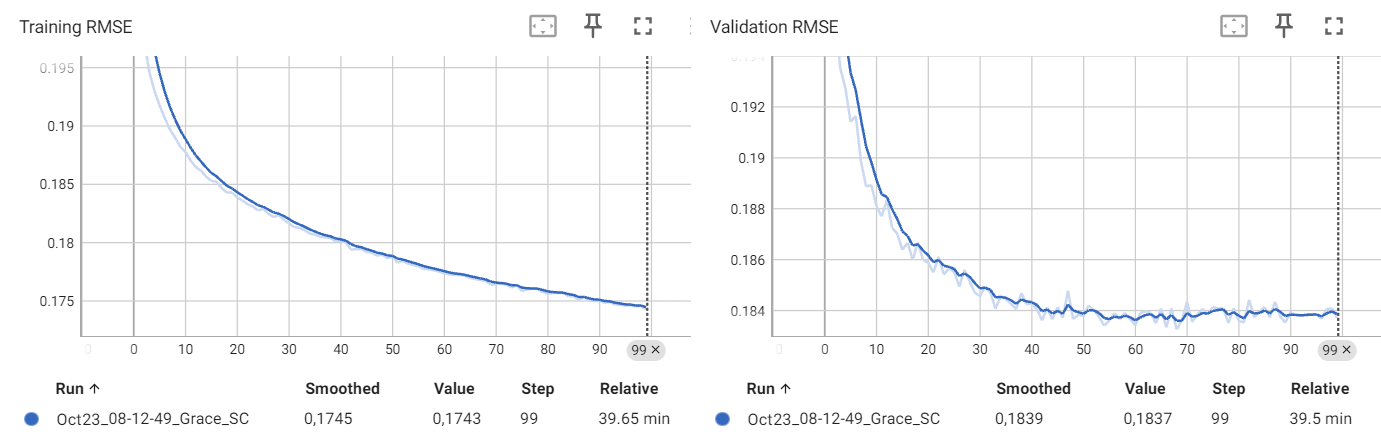

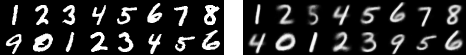

In [95]:
model2 = AutoencoderConvUpsample()
train_model(model2, train_loader, val_loader)

Epoch 1/100 - Training RMSE: 0.2199
Epoch 1/100 - Validation RMSE: 0.2039
Checkpoint guardado
Epoch 2/100 - Training RMSE: 0.2012
Epoch 2/100 - Validation RMSE: 0.1987
Checkpoint guardado
Epoch 3/100 - Training RMSE: 0.1970
Epoch 3/100 - Validation RMSE: 0.1966
Checkpoint guardado
Epoch 4/100 - Training RMSE: 0.1948
Epoch 4/100 - Validation RMSE: 0.1938
Checkpoint guardado
Epoch 5/100 - Training RMSE: 0.1931
Epoch 5/100 - Validation RMSE: 0.1924
Checkpoint guardado
Epoch 6/100 - Training RMSE: 0.1919
Epoch 6/100 - Validation RMSE: 0.1918
Checkpoint guardado
Epoch 7/100 - Training RMSE: 0.1910
Epoch 7/100 - Validation RMSE: 0.1915
Checkpoint guardado
Epoch 8/100 - Training RMSE: 0.1900
Epoch 8/100 - Validation RMSE: 0.1899
Checkpoint guardado
Epoch 9/100 - Training RMSE: 0.1897
Epoch 9/100 - Validation RMSE: 0.1894
Checkpoint guardado
Epoch 10/100 - Training RMSE: 0.1887
Epoch 10/100 - Validation RMSE: 0.1891
Checkpoint guardado
Epoch 11/100 - Training RMSE: 0.1883
Epoch 11/100 - Valida

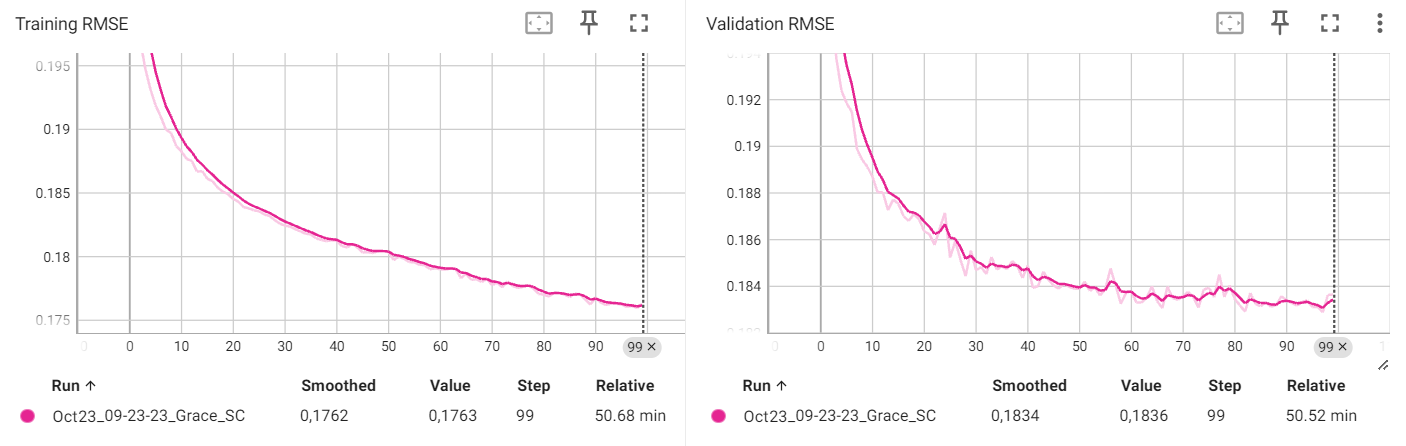

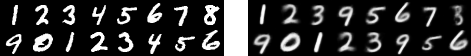

In [105]:
model3 = AutoencoderInterpolation()
train_model(model3, train_loader, val_loader)

Epoch 1/100 - Training RMSE: 0.2222
Epoch 1/100 - Validation RMSE: 0.2047
Checkpoint guardado
Epoch 2/100 - Training RMSE: 0.2017
Epoch 2/100 - Validation RMSE: 0.1983
Checkpoint guardado
Epoch 3/100 - Training RMSE: 0.1965
Epoch 3/100 - Validation RMSE: 0.1945
Checkpoint guardado
Epoch 4/100 - Training RMSE: 0.1937
Epoch 4/100 - Validation RMSE: 0.1923
Checkpoint guardado
Epoch 5/100 - Training RMSE: 0.1919
Epoch 5/100 - Validation RMSE: 0.1916
Checkpoint guardado
Epoch 6/100 - Training RMSE: 0.1904
Epoch 6/100 - Validation RMSE: 0.1904
Checkpoint guardado
Epoch 7/100 - Training RMSE: 0.1894
Epoch 7/100 - Validation RMSE: 0.1909
Epoch 8/100 - Training RMSE: 0.1886
Epoch 8/100 - Validation RMSE: 0.1890
Checkpoint guardado
Epoch 9/100 - Training RMSE: 0.1878
Epoch 9/100 - Validation RMSE: 0.1885
Checkpoint guardado
Epoch 10/100 - Training RMSE: 0.1872
Epoch 10/100 - Validation RMSE: 0.1878
Checkpoint guardado
Epoch 11/100 - Training RMSE: 0.1867
Epoch 11/100 - Validation RMSE: 0.1871
Ch

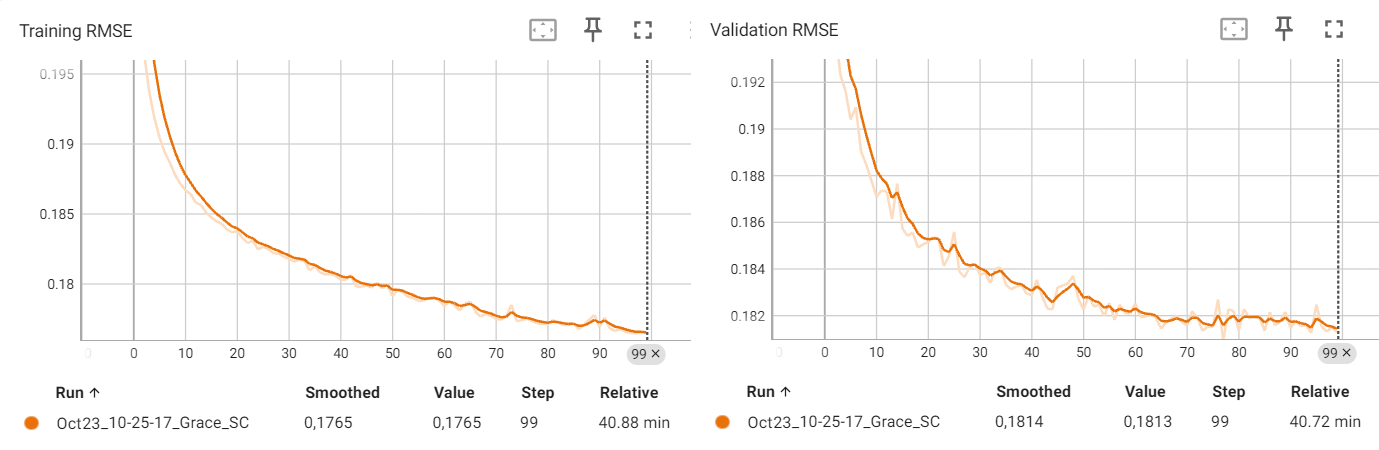

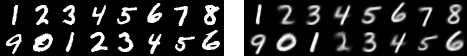

__4. Train your models using an L2 reconstruction loss for 100 epochs and Adam with a
learning rate 0.001. Please provide the reconstruction error curves (using RMSE metric
average for all pixels) for the training and validation data sets for your three models using
TensorBoard or wandb.__ __Which one is the best architecture and which one you would stick
with? Why?__

    DecoderConvTranspose (Blue Graph): This model achieves the lowest RMSE in both training and validation, suggesting it   is the most effective at reconstructing the MNIST dataset images. The use of transposed convolutions seems to be            beneficial, as they can directly learn the upsampling filters during the training process, potentially resulting in     more detailed and accurate reconstructions.

    DecoderConvUpsample (Fuchsia Graph): The performance of this decoder is slightly inferior to the DecoderConvTranspose, but it still maintains a competitive RMSE, especially in the validation phase. This decoder uses nearest neighbor           upsampling followed by convolutions, which is a simpler approach that can sometimes lead to less refined outputs.       Despite this, the model is still effective and exhibits good generalization from the training to the validation              dataset.

    DecoderInterpolation (Orange Graph): The decoder with interpolation has the highest RMSE among the three. It uses a fixed method for upsampling (nearest interpolation) followed by convolutions, which might be less flexible than the          learned parameters of transposed convolutions in the DecoderConvTranspose. The interpolation technique may result in a loss of some high-frequency details, which could explain the slightly higher RMSE.

In summary, the DecoderConvTranspose is the most successful at minimizing the RMSE, likely due to its ability to learn the upsampling process. The DecoderConvUpsample offers a simple yet effective approach, but it doesn't quite match the performance of the learned transposed convolutions. The DecoderInterpolation, while still a valid approach, seems to be less suited for this task compared to the other two, potentially due to its less nuanced way of increasing the image resolution. Each decoder has its merits, but the DecoderConvTranspose appears to provide the best balance between complexity and performance for this specific application.

Comparison between 3 decoders

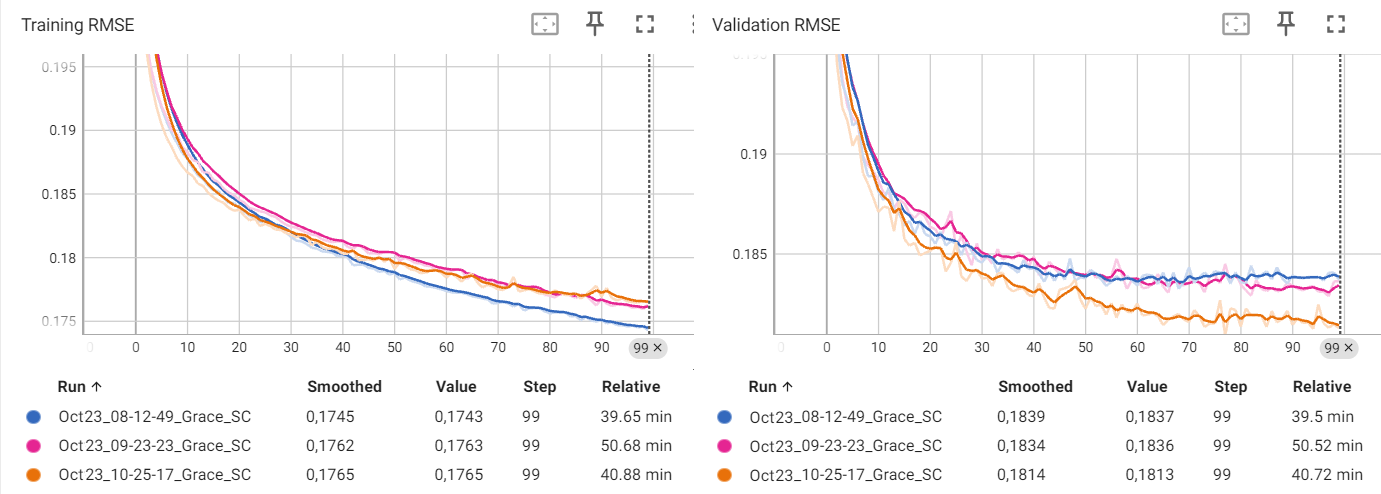

__5. Do you observe any overfitting in the obtained training curves? How would you select the
best weights over the epochs for a specific architecture?__

No, I don't observe any clear signs of overfitting. The RMSE for both the training and validation sets is decreasing and stabilizing, which indicates that the models are generalizing well to unseen data. There is no significant uptick in the validation RMSE, which would suggest that the model is beginning to memorize the training data rather than learning generalizable patterns.

To select the best weights over the epochs for a specific architecture, I would typically use a combination of checkpointing and early stopping. I'd save the model's weights whenever there is an improvement in validation RMSE. This way, even if the model begins to overfit later during training, I can always revert to the best-performing checkpoint. Early stopping would be employed as an additional safeguard to halt training if the validation loss starts to increase consistently, which is a sign of overfitting.

Given that the validation RMSE in my current models does not show an upward trend, I would choose the weights from the last epoch for each model. However, I would still implement checkpointing during training as a best practice, ensuring that I can always select the best weights based on validation performance.

__6. Please retrain your models now using binary cross-entropy as the reconstruction loss.__


Segunda versión de Loss binary cross-entropy (BCE)

In [108]:
def bce_loss(recon_x, x):
    bce_loss = nn.BCELoss()
    return bce_loss(recon_x, x)

def train_model_bce(model, train_loader, val_loader, epochs=100, learning_rate=0.001):
    model.to(device)  
    writer = SummaryWriter()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss = float("inf")  
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            imgs, _ = data
            imgs = imgs.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = bce_loss(outputs, imgs)#### cambio
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        writer.add_scalar('Training Loss', train_loss, epoch)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}")
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                imgs, _ = data
                imgs = imgs.to(device) 
                outputs = model(imgs)
                loss = bce_loss(outputs, imgs)
                val_loss += loss.item()
                if epoch % 10 == 0:
                    writer.add_images('Input', imgs, epoch)
                    writer.add_images('Reconstruction', outputs, epoch)
            val_loss /= len(val_loader)
            writer.add_scalar('Validation Loss', val_loss, epoch)
            print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'model_best_{type(model).__name__}.pth')
            print("Checkpoint guardado")
    writer.close()

In [109]:
model4 = AutoencoderConvTranspose()
train_model_bce(model4, train_loader, val_loader)

Epoch 1/100 - Training Loss: 0.2132
Epoch 1/100 - Validation Loss: 0.1882
Checkpoint guardado
Epoch 2/100 - Training Loss: 0.1842
Epoch 2/100 - Validation Loss: 0.1821
Checkpoint guardado
Epoch 3/100 - Training Loss: 0.1789
Epoch 3/100 - Validation Loss: 0.1775
Checkpoint guardado
Epoch 4/100 - Training Loss: 0.1762
Epoch 4/100 - Validation Loss: 0.1750
Checkpoint guardado
Epoch 5/100 - Training Loss: 0.1742
Epoch 5/100 - Validation Loss: 0.1741
Checkpoint guardado
Epoch 6/100 - Training Loss: 0.1728
Epoch 6/100 - Validation Loss: 0.1728
Checkpoint guardado
Epoch 7/100 - Training Loss: 0.1716
Epoch 7/100 - Validation Loss: 0.1714
Checkpoint guardado
Epoch 8/100 - Training Loss: 0.1705
Epoch 8/100 - Validation Loss: 0.1717
Epoch 9/100 - Training Loss: 0.1696
Epoch 9/100 - Validation Loss: 0.1695
Checkpoint guardado
Epoch 10/100 - Training Loss: 0.1691
Epoch 10/100 - Validation Loss: 0.1702
Epoch 11/100 - Training Loss: 0.1686
Epoch 11/100 - Validation Loss: 0.1691
Checkpoint guardado
Ep

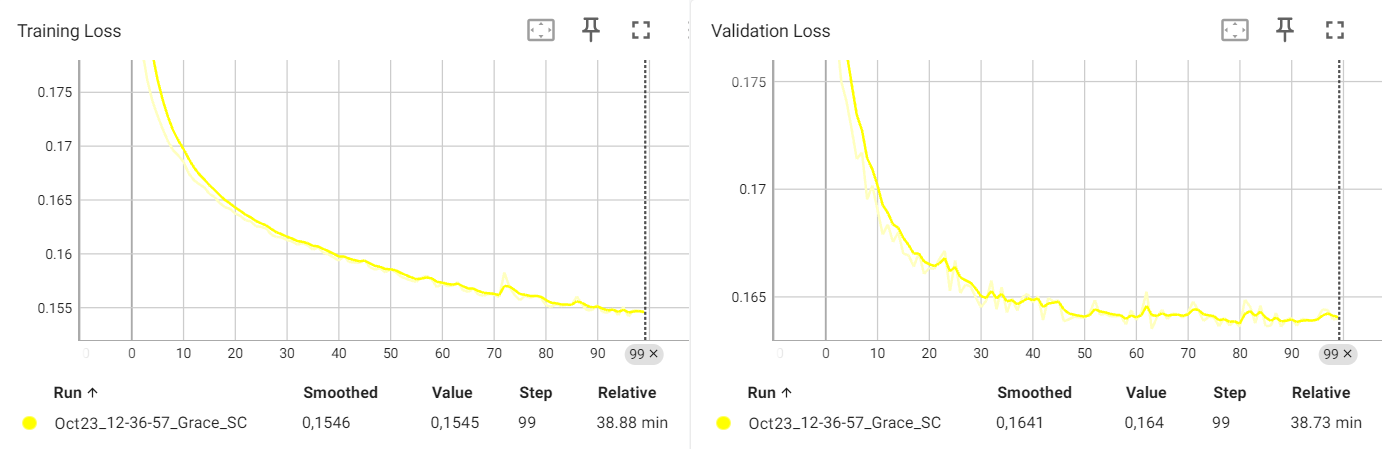

<img src="model1_bce_num.png" width="800" height="600"/>

In [110]:
model5 = AutoencoderConvUpsample()
train_model_bce(model5, train_loader, val_loader)

Epoch 1/100 - Training Loss: 0.2112
Epoch 1/100 - Validation Loss: 0.1904
Checkpoint guardado
Epoch 2/100 - Training Loss: 0.1858
Epoch 2/100 - Validation Loss: 0.1823
Checkpoint guardado
Epoch 3/100 - Training Loss: 0.1800
Epoch 3/100 - Validation Loss: 0.1792
Checkpoint guardado
Epoch 4/100 - Training Loss: 0.1772
Epoch 4/100 - Validation Loss: 0.1761
Checkpoint guardado
Epoch 5/100 - Training Loss: 0.1750
Epoch 5/100 - Validation Loss: 0.1749
Checkpoint guardado
Epoch 6/100 - Training Loss: 0.1733
Epoch 6/100 - Validation Loss: 0.1730
Checkpoint guardado
Epoch 7/100 - Training Loss: 0.1722
Epoch 7/100 - Validation Loss: 0.1722
Checkpoint guardado
Epoch 8/100 - Training Loss: 0.1712
Epoch 8/100 - Validation Loss: 0.1706
Checkpoint guardado
Epoch 9/100 - Training Loss: 0.1700
Epoch 9/100 - Validation Loss: 0.1705
Checkpoint guardado
Epoch 10/100 - Training Loss: 0.1694
Epoch 10/100 - Validation Loss: 0.1700
Checkpoint guardado
Epoch 11/100 - Training Loss: 0.1687
Epoch 11/100 - Valida

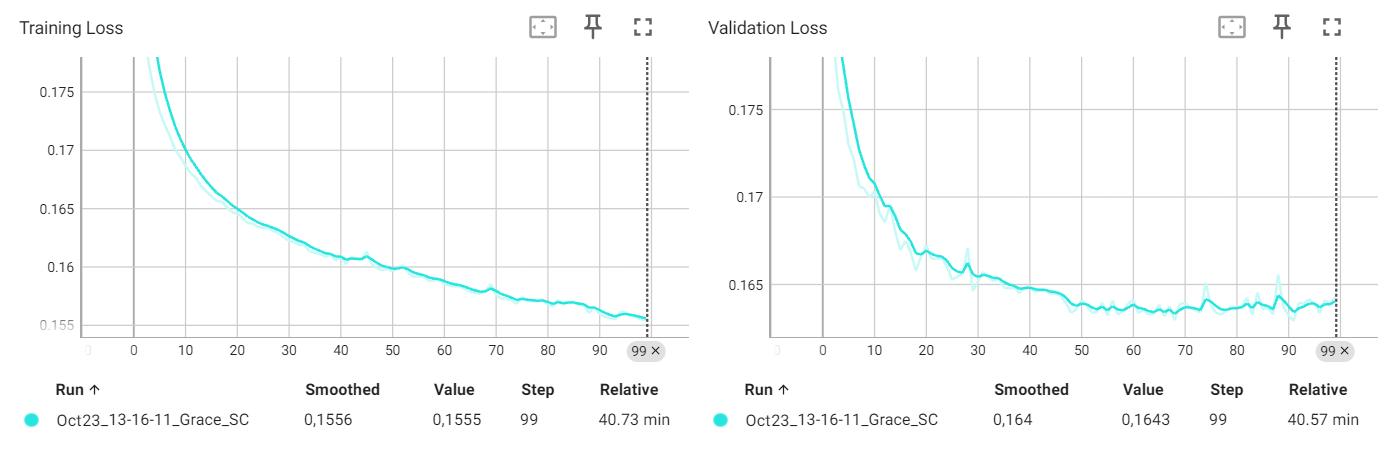

<img src="numeros2_bce.png" width="800" height="600"/>

In [111]:
model6 = AutoencoderInterpolation()
train_model_bce(model6, train_loader, val_loader)

Epoch 1/100 - Training Loss: 0.2107
Epoch 1/100 - Validation Loss: 0.1913
Checkpoint guardado
Epoch 2/100 - Training Loss: 0.1851
Epoch 2/100 - Validation Loss: 0.1813
Checkpoint guardado
Epoch 3/100 - Training Loss: 0.1796
Epoch 3/100 - Validation Loss: 0.1783
Checkpoint guardado
Epoch 4/100 - Training Loss: 0.1767
Epoch 4/100 - Validation Loss: 0.1753
Checkpoint guardado
Epoch 5/100 - Training Loss: 0.1748
Epoch 5/100 - Validation Loss: 0.1741
Checkpoint guardado
Epoch 6/100 - Training Loss: 0.1733
Epoch 6/100 - Validation Loss: 0.1735
Checkpoint guardado
Epoch 7/100 - Training Loss: 0.1719
Epoch 7/100 - Validation Loss: 0.1719
Checkpoint guardado
Epoch 8/100 - Training Loss: 0.1708
Epoch 8/100 - Validation Loss: 0.1713
Checkpoint guardado
Epoch 9/100 - Training Loss: 0.1700
Epoch 9/100 - Validation Loss: 0.1703
Checkpoint guardado
Epoch 10/100 - Training Loss: 0.1690
Epoch 10/100 - Validation Loss: 0.1702
Checkpoint guardado
Epoch 11/100 - Training Loss: 0.1683
Epoch 11/100 - Valida

Epoch 100/100 - Training Loss: 0.1552
Epoch 100/100 - Validation Loss: 0.1633


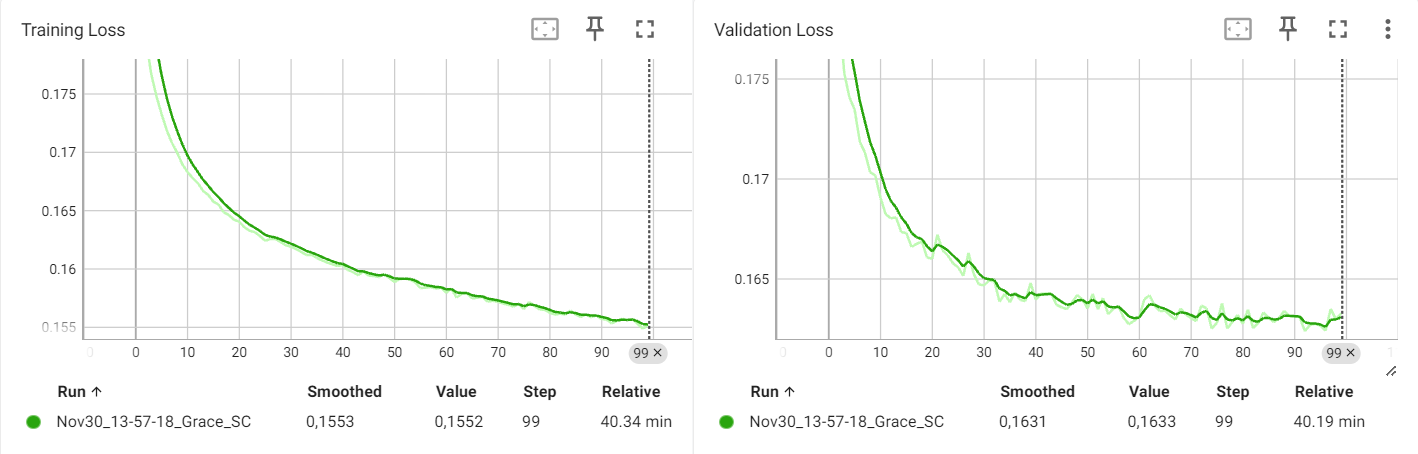

<img src="numeros3_bce.png" width="800" height="600"/>

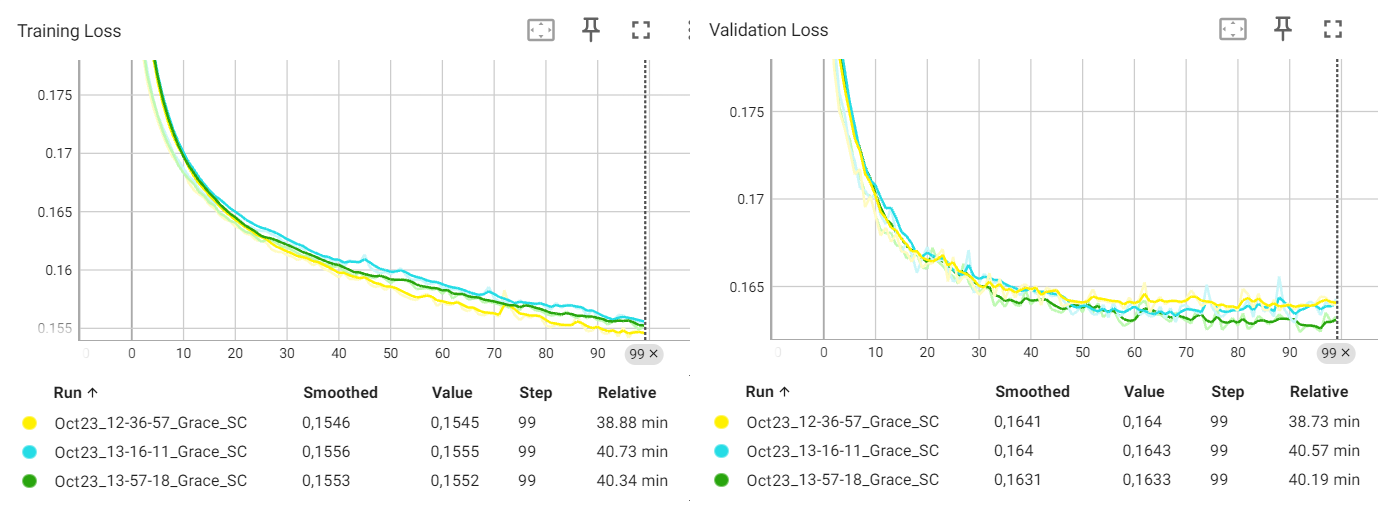

__What do you observe compared when using L2?__

With L2 (MSE) Loss:

    The blue, fuchsia, and orange autoencoders display a swift decrease in both training and validation RMSE in the initial iterations, after which the metrics stabilize.
    Stabilization occurs around the 100-step mark, taking about 40 minutes for all cases.
    The final training RMSE settles at approximately 0.1745, 0.1762, and 0.1765, respectively, and for validation around    0.1839, 0.1834, and 0.1814.
    Convergence is quick at the start but plateaus after roughly 20 steps.

With BCE Loss :

    The yellow, sky blue, and green autoencoders show a smoother and more continuous decrease in both training and         validation loss.
    The loss stabilizes at lower values than with L2, around 0.1546, 0.1556, and 0.1553 for training, and 0.1641, 0.1643,   and 0.1631 for validation.
    These also stabilize near the 100-step mark with similar timings to L2, but they achieve lower loss values.
    The loss reduction is more uniform and lacks the dramatic initial drops seen with L2.

Comparison:

    Loss behavior with BCE is smoother and more stable compared to L2, stabilizing at lower values. This might indicate    that BCE is a more effective loss metric for this problem, at least with the current hyperparameters and architecture  in use.
    BCE loss seems to facilitate finer tuning during training, which might result in a model that generalizes better on     unseen data, as suggested by the lower validation loss compared to L2.
    The choice between L2 and BCE may depend on the data type and specific task; BCE tends to perform well with              classification problems or when the output is probabilistic, while L2 is commonly used in regression tasks.

In summary, while both methods achieve convergence, BCE loss demonstrates a more stable behavior and reaches convergence at a lower value than L2, suggesting a potential preference for BCE in this particular scenario.

__Why it is possible to use binary crossentropy (BCE) with the data from MNIST?__

Binary Cross-Entropy (BCE) is well-suited for the MNIST dataset because after normalization, the grayscale pixel values lie within the [0,1] range. BCE is designed for such binary or near-binary values, especially when the model's output is bounded between [0,1], typically achieved with a sigmoid activation function in the final layer. In the context of autoencoders, the task of reconstructing an image can be seen as a set of binary classifications for each pixel, thus making BCE an appropriate choice for the loss function. The reconstruction considers whether each pixel should be activated (close to 1) or not (close to 0), aligning with the binary nature of BCE.

Moreover, the charts comparing training and validation loss suggest that BCE provides better results for the MNIST dataset compared to L2 loss. This may be due to BCE offering more informative gradients for optimization or being more inherently aligned with the binary nature of the normalized MNIST pixel values.

__7. Change the dimension of the code from 2 to 7 in your encoder (and operations in the
decoder if needed). Please show visualizations for five reconstructed numbers for each
loss.__

In [123]:
model7 = AutoencoderConvTranspose()
train_model(model7, train_loader, val_loader)

Epoch 1/100 - Training RMSE: 0.1701
Epoch 1/100 - Validation RMSE: 0.1411
Checkpoint guardado
Epoch 2/100 - Training RMSE: 0.1355
Epoch 2/100 - Validation RMSE: 0.1307
Checkpoint guardado
Epoch 3/100 - Training RMSE: 0.1296
Epoch 3/100 - Validation RMSE: 0.1273
Checkpoint guardado
Epoch 4/100 - Training RMSE: 0.1263
Epoch 4/100 - Validation RMSE: 0.1255
Checkpoint guardado
Epoch 5/100 - Training RMSE: 0.1238
Epoch 5/100 - Validation RMSE: 0.1241
Checkpoint guardado
Epoch 6/100 - Training RMSE: 0.1220
Epoch 6/100 - Validation RMSE: 0.1220
Checkpoint guardado
Epoch 7/100 - Training RMSE: 0.1206
Epoch 7/100 - Validation RMSE: 0.1232
Epoch 8/100 - Training RMSE: 0.1194
Epoch 8/100 - Validation RMSE: 0.1205
Checkpoint guardado
Epoch 9/100 - Training RMSE: 0.1184
Epoch 9/100 - Validation RMSE: 0.1198
Checkpoint guardado
Epoch 10/100 - Training RMSE: 0.1175
Epoch 10/100 - Validation RMSE: 0.1202
Epoch 11/100 - Training RMSE: 0.1166
Epoch 11/100 - Validation RMSE: 0.1199
Epoch 12/100 - Trainin

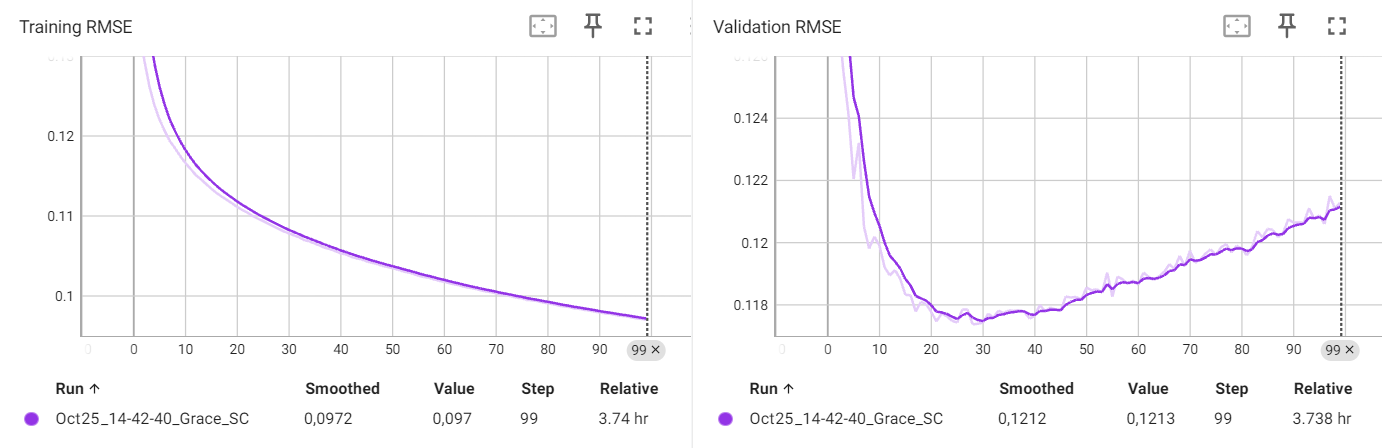

<img src="model7_nums.png" width="800" height="600"/>

In [124]:
model8 = AutoencoderConvUpsample()
train_model(model8, train_loader, val_loader)

Epoch 1/100 - Training RMSE: 0.1704
Epoch 1/100 - Validation RMSE: 0.1398
Checkpoint guardado
Epoch 2/100 - Training RMSE: 0.1351
Epoch 2/100 - Validation RMSE: 0.1309
Checkpoint guardado
Epoch 3/100 - Training RMSE: 0.1295
Epoch 3/100 - Validation RMSE: 0.1280
Checkpoint guardado
Epoch 4/100 - Training RMSE: 0.1264
Epoch 4/100 - Validation RMSE: 0.1262
Checkpoint guardado
Epoch 5/100 - Training RMSE: 0.1241
Epoch 5/100 - Validation RMSE: 0.1231
Checkpoint guardado
Epoch 6/100 - Training RMSE: 0.1225
Epoch 6/100 - Validation RMSE: 0.1228
Checkpoint guardado
Epoch 7/100 - Training RMSE: 0.1210
Epoch 7/100 - Validation RMSE: 0.1224
Checkpoint guardado
Epoch 8/100 - Training RMSE: 0.1200
Epoch 8/100 - Validation RMSE: 0.1217
Checkpoint guardado
Epoch 9/100 - Training RMSE: 0.1189
Epoch 9/100 - Validation RMSE: 0.1209
Checkpoint guardado
Epoch 10/100 - Training RMSE: 0.1181
Epoch 10/100 - Validation RMSE: 0.1210
Epoch 11/100 - Training RMSE: 0.1172
Epoch 11/100 - Validation RMSE: 0.1202
Ch

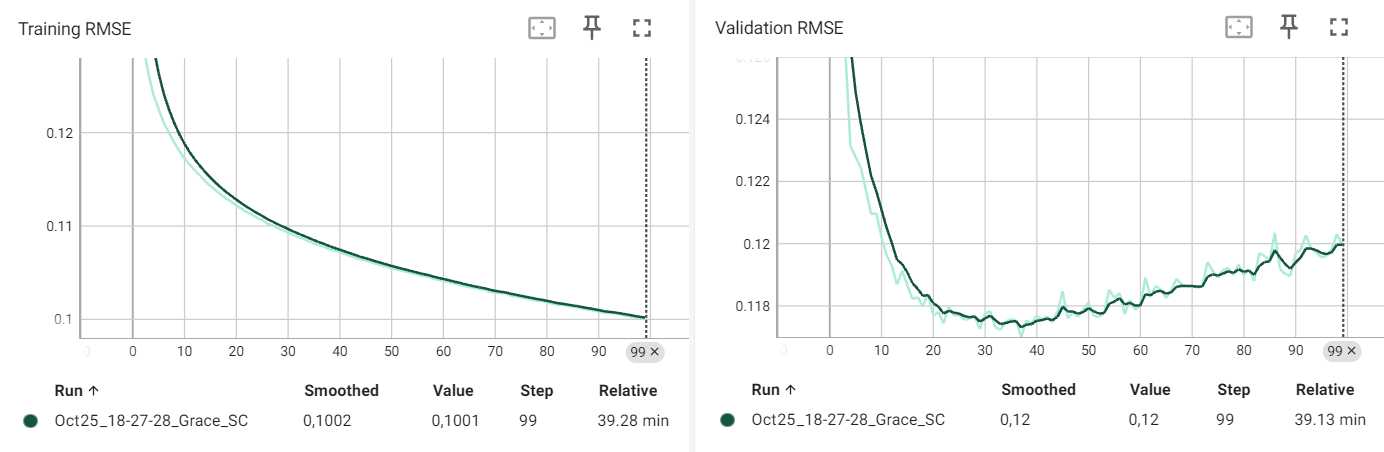

<img src="model8_nums.png" width="800" height="600"/>

In [125]:
model9 = AutoencoderInterpolation()
train_model(model9, train_loader, val_loader)

Epoch 1/100 - Training RMSE: 0.1704
Epoch 1/100 - Validation RMSE: 0.1400
Checkpoint guardado
Epoch 2/100 - Training RMSE: 0.1364
Epoch 2/100 - Validation RMSE: 0.1321
Checkpoint guardado
Epoch 3/100 - Training RMSE: 0.1306
Epoch 3/100 - Validation RMSE: 0.1291
Checkpoint guardado
Epoch 4/100 - Training RMSE: 0.1272
Epoch 4/100 - Validation RMSE: 0.1268
Checkpoint guardado
Epoch 5/100 - Training RMSE: 0.1249
Epoch 5/100 - Validation RMSE: 0.1241
Checkpoint guardado
Epoch 6/100 - Training RMSE: 0.1231
Epoch 6/100 - Validation RMSE: 0.1227
Checkpoint guardado
Epoch 7/100 - Training RMSE: 0.1218
Epoch 7/100 - Validation RMSE: 0.1223
Checkpoint guardado
Epoch 8/100 - Training RMSE: 0.1205
Epoch 8/100 - Validation RMSE: 0.1220
Checkpoint guardado
Epoch 9/100 - Training RMSE: 0.1194
Epoch 9/100 - Validation RMSE: 0.1216
Checkpoint guardado
Epoch 10/100 - Training RMSE: 0.1185
Epoch 10/100 - Validation RMSE: 0.1207
Checkpoint guardado
Epoch 11/100 - Training RMSE: 0.1177
Epoch 11/100 - Valida

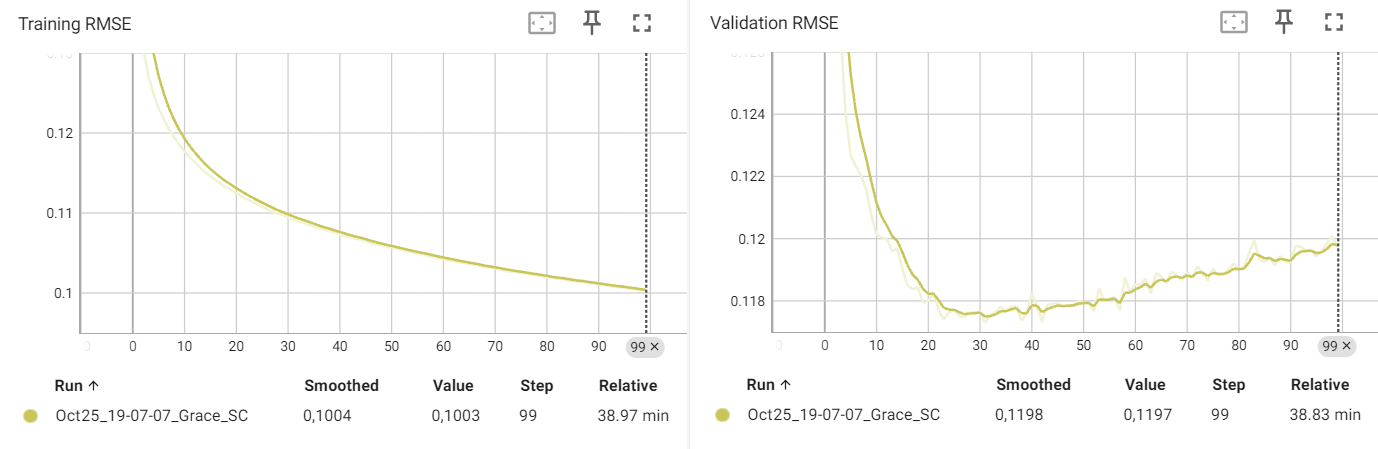

<img src="model9_nums.png" width="800" height="600"/>

In [126]:
model10 = AutoencoderConvTranspose()
train_model_bce(model10, train_loader, val_loader)

Epoch 1/100 - Training Loss: 0.1646
Epoch 1/100 - Validation Loss: 0.1254
Checkpoint guardado
Epoch 2/100 - Training Loss: 0.1217
Epoch 2/100 - Validation Loss: 0.1185
Checkpoint guardado
Epoch 3/100 - Training Loss: 0.1165
Epoch 3/100 - Validation Loss: 0.1151
Checkpoint guardado
Epoch 4/100 - Training Loss: 0.1136
Epoch 4/100 - Validation Loss: 0.1131
Checkpoint guardado
Epoch 5/100 - Training Loss: 0.1116
Epoch 5/100 - Validation Loss: 0.1118
Checkpoint guardado
Epoch 6/100 - Training Loss: 0.1101
Epoch 6/100 - Validation Loss: 0.1115
Checkpoint guardado
Epoch 7/100 - Training Loss: 0.1088
Epoch 7/100 - Validation Loss: 0.1096
Checkpoint guardado
Epoch 8/100 - Training Loss: 0.1078
Epoch 8/100 - Validation Loss: 0.1088
Checkpoint guardado
Epoch 9/100 - Training Loss: 0.1070
Epoch 9/100 - Validation Loss: 0.1086
Checkpoint guardado
Epoch 10/100 - Training Loss: 0.1062
Epoch 10/100 - Validation Loss: 0.1075
Checkpoint guardado
Epoch 11/100 - Training Loss: 0.1056
Epoch 11/100 - Valida

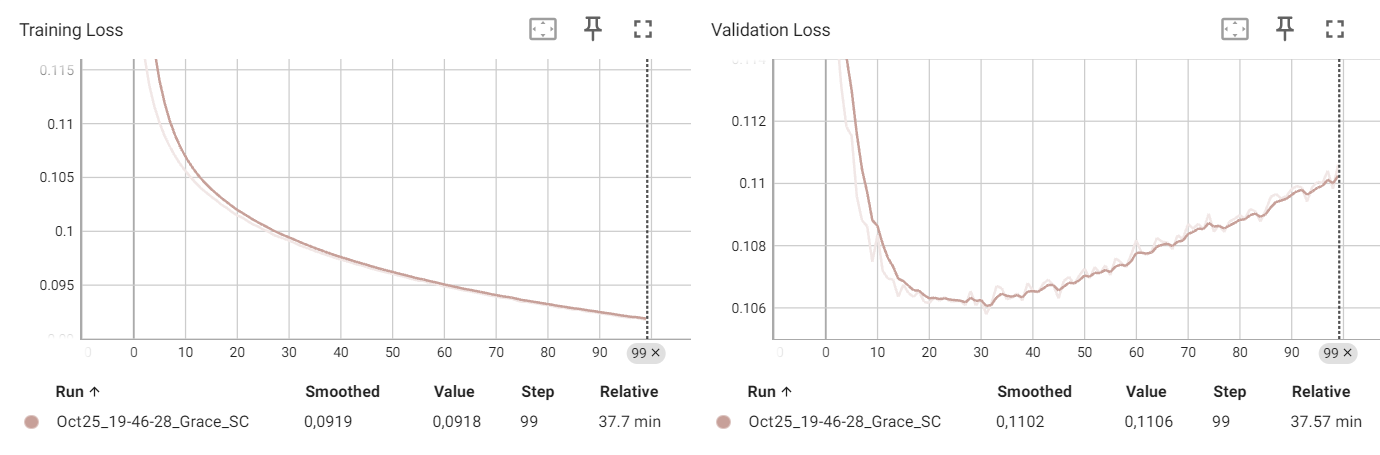

<img src="model10_nums.png" width="800" height="600"/>

In [127]:
model11 = AutoencoderConvUpsample()
train_model_bce(model11, train_loader, val_loader)

Epoch 1/100 - Training Loss: 0.1570
Epoch 1/100 - Validation Loss: 0.1233
Checkpoint guardado
Epoch 2/100 - Training Loss: 0.1193
Epoch 2/100 - Validation Loss: 0.1152
Checkpoint guardado
Epoch 3/100 - Training Loss: 0.1141
Epoch 3/100 - Validation Loss: 0.1128
Checkpoint guardado
Epoch 4/100 - Training Loss: 0.1113
Epoch 4/100 - Validation Loss: 0.1109
Checkpoint guardado
Epoch 5/100 - Training Loss: 0.1093
Epoch 5/100 - Validation Loss: 0.1094
Checkpoint guardado
Epoch 6/100 - Training Loss: 0.1079
Epoch 6/100 - Validation Loss: 0.1078
Checkpoint guardado
Epoch 7/100 - Training Loss: 0.1068
Epoch 7/100 - Validation Loss: 0.1073
Checkpoint guardado
Epoch 8/100 - Training Loss: 0.1058
Epoch 8/100 - Validation Loss: 0.1065
Checkpoint guardado
Epoch 9/100 - Training Loss: 0.1050
Epoch 9/100 - Validation Loss: 0.1062
Checkpoint guardado
Epoch 10/100 - Training Loss: 0.1044
Epoch 10/100 - Validation Loss: 0.1064
Epoch 11/100 - Training Loss: 0.1038
Epoch 11/100 - Validation Loss: 0.1055
Ch

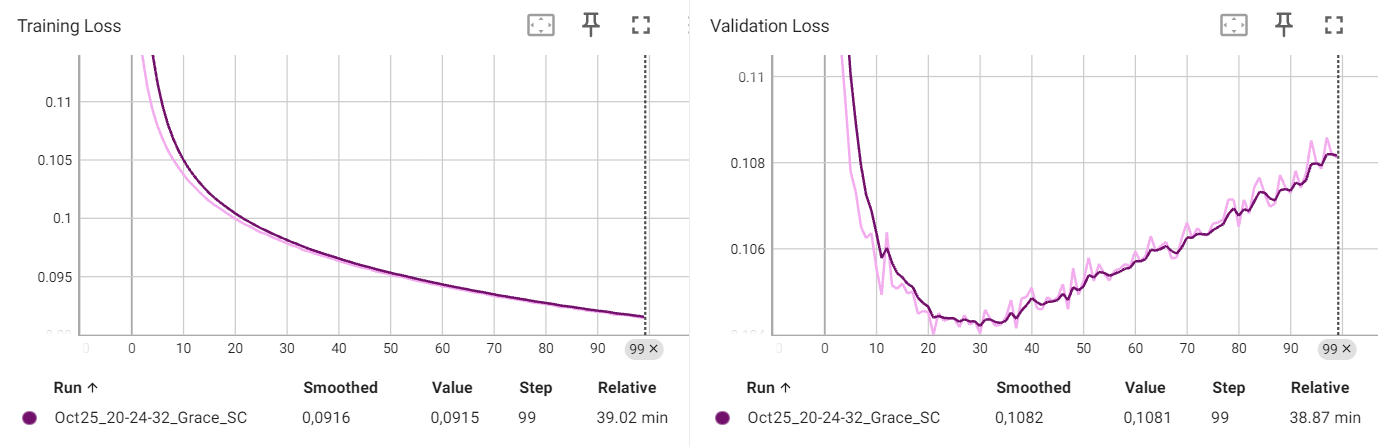

<img src="model11_nums.png" width="800" height="600"/>

In [128]:
model12 = AutoencoderInterpolation()
train_model_bce(model12, train_loader, val_loader)

Epoch 1/100 - Training Loss: 0.1600
Epoch 1/100 - Validation Loss: 0.1241
Checkpoint guardado
Epoch 2/100 - Training Loss: 0.1199
Epoch 2/100 - Validation Loss: 0.1166
Checkpoint guardado
Epoch 3/100 - Training Loss: 0.1152
Epoch 3/100 - Validation Loss: 0.1134
Checkpoint guardado
Epoch 4/100 - Training Loss: 0.1124
Epoch 4/100 - Validation Loss: 0.1115
Checkpoint guardado
Epoch 5/100 - Training Loss: 0.1106
Epoch 5/100 - Validation Loss: 0.1110
Checkpoint guardado
Epoch 6/100 - Training Loss: 0.1090
Epoch 6/100 - Validation Loss: 0.1090
Checkpoint guardado
Epoch 7/100 - Training Loss: 0.1079
Epoch 7/100 - Validation Loss: 0.1081
Checkpoint guardado
Epoch 8/100 - Training Loss: 0.1069
Epoch 8/100 - Validation Loss: 0.1075
Checkpoint guardado
Epoch 9/100 - Training Loss: 0.1062
Epoch 9/100 - Validation Loss: 0.1073
Checkpoint guardado
Epoch 10/100 - Training Loss: 0.1054
Epoch 10/100 - Validation Loss: 0.1067
Checkpoint guardado
Epoch 11/100 - Training Loss: 0.1048
Epoch 11/100 - Valida

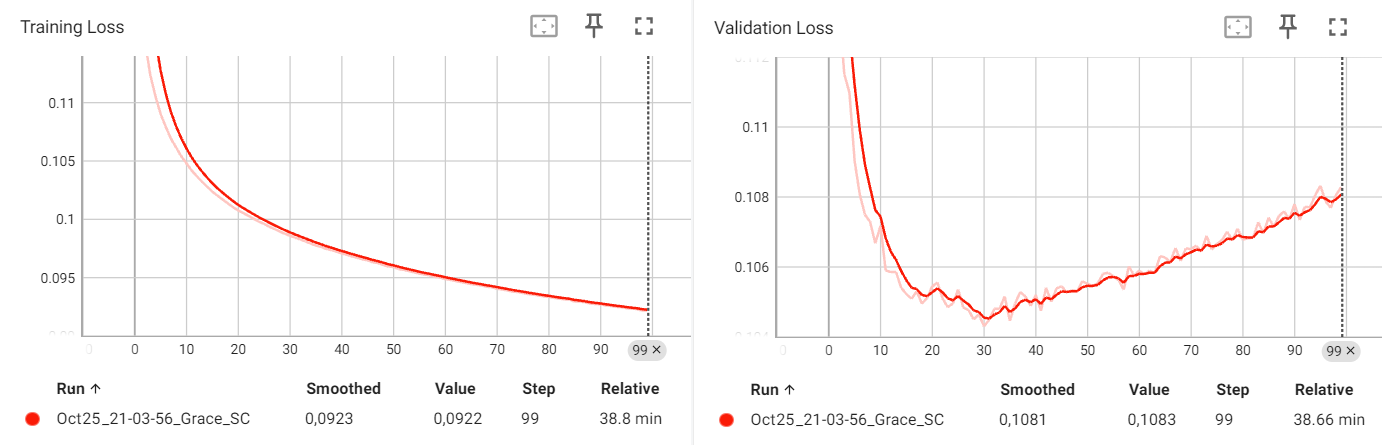

<img src="model12_nums.png" width="800" height="600"/>

# Part III - Learning to Perform Addition from Images

__This model has three main components: encoder (E), decoder (D) and code addition model (P)__

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=7)

    def forward(self, x):
        #print(f"Encoder Input Shape: {x.shape}")
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, start_dim=1)
        #print(f"Encoder Flattened Shape: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #print(f"Encoder Output Shape: {x.shape}")
        return x
class DecoderConvTranspose(nn.Module):
    def __init__(self):
        super(DecoderConvTranspose, self).__init__()
        self.fc1 = nn.Linear(7, 256)
        self.fc2 = nn.Linear(256, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # Tamaño después: 14x14
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # Tamaño después: 28x28
        self.deconv3 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1) 

    def forward(self, x):
        #print(f"Decoder Input Shape: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 4, 4)
        #print(f"Decoder Reshaped Shape: {x.shape}")
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        #print(f"Decoder Output Shape: {x.shape}")
        return x

__1. The first thing we going to need to make is a data preprocessing to generate new samples that will make your task. We will restrict ourselves to sums that results in numbers of one digit, i.e., 1+8 and 9+0 are fine but 1+9 or 8+3 are not valid operations. For each resulting number we should create tuples (Input, Output) such as possible inputs combinations that results into a specific number:__

• Possible input combinations for the number 0: [(0, 0)]

• ...

• Possible input combinations for the number 4: [(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]

• Possible input combinations for the number 5: [(0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5,0)]

In [161]:
def transform_data_add(x_train, y_train, img_size=[32, 32]):
    x_train_np = x_train.cpu().numpy()
    y_train_np = y_train.cpu().numpy()

    number_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    value_add_list = [np.arange(number + 1) for number in number_list]

    img_in, img_out, value_in = [], [], []
    samples_count = []

    for number, value_add in zip(number_list, value_add_list):
        samples_number = [] 
        for i in value_add:
            indices_for_i = np.where(y_train_np == i)[0]
            indices_for_number = np.where(y_train_np == number)[0]
            min_len = min(len(indices_for_i), len(indices_for_number))

            selected_indices_for_i = indices_for_i[:min_len]
            selected_indices_for_number = indices_for_number[:min_len]

            # Shuffle to avoid overfitting if the number is the same
            if number - i == 0:
                np.random.shuffle(selected_indices_for_number)

            img_in.extend(x_train_np[selected_indices_for_i])
            img_out.extend(x_train_np[selected_indices_for_number])
            value_in.extend([number - i] * min_len)
            samples_number.append(min_len)  

        samples_count.append(samples_number)

    img_in = [cv.resize(item, tuple(img_size)) for item in img_in]
    img_out = [cv.resize(item, tuple(img_size)) for item in img_out]
    
    img_in = np.array(img_in) / 255.0 #esto me asegura que mis datos este normalizados nuevamente RECORDAR NO CAMBIAR
    img_out = np.array(img_out) / 255.0
    
    # Convert to tensors and add a channel dimension
    img_in = torch.Tensor(img_in).unsqueeze(1)
    img_out = torch.Tensor(img_out).unsqueeze(1)
    value_in = torch.Tensor(value_in)

    print("Distribution of values:", samples_count)
    print("Values to add:", value_in.numpy())

    return img_in, value_in, img_out

Data intake MNIST

In [162]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset_ = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset_ = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader_ = DataLoader(train_dataset_, batch_size=32, shuffle=True)
val_loader_ = DataLoader(val_dataset_, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [163]:
#Verificación de mis datos antes de transformarlos
for images, _  in train_loader_:
    print("Mínimo valor en el lote:", images.min().item())
    print("Máximo valor en el lote:", images.max().item())
    print("Media del lote:", images.mean().item())
    print("Desviación estándar del lote:", images.std().item())
    break 

Mínimo valor en el lote: 0.0
Máximo valor en el lote: 1.0
Media del lote: 0.13451988995075226
Desviación estándar del lote: 0.313997745513916


In [164]:
x_train_, y_train_ = train_dataset_.data, train_dataset_.targets
x_val_, y_val_ = val_dataset_.data, val_dataset_.targets

In [165]:
print("Training image dimension:", x_train_.shape)
print("Validation image dimension:", x_val_.shape)

Training image dimension: torch.Size([60000, 28, 28])
Validation image dimension: torch.Size([10000, 28, 28])


In [166]:
img_in, value_in, img_out = transform_data_add(x_train_, y_train_)
img_in_val, value_in_val, img_out_val = transform_data_add(x_val_, y_val_)

Distribution of values: [[5923], [5923, 6742], [5923, 5958, 5958], [5923, 6131, 5958, 6131], [5842, 5842, 5842, 5842, 5842], [5421, 5421, 5421, 5421, 5421, 5421], [5918, 5918, 5918, 5918, 5842, 5421, 5918], [5923, 6265, 5958, 6131, 5842, 5421, 5918, 6265], [5851, 5851, 5851, 5851, 5842, 5421, 5851, 5851, 5851], [5923, 5949, 5949, 5949, 5842, 5421, 5918, 5949, 5851, 5949]]
Values to add: [0. 0. 0. ... 0. 0. 0.]
Distribution of values: [[980], [980, 1135], [980, 1032, 1032], [980, 1010, 1010, 1010], [980, 982, 982, 982, 982], [892, 892, 892, 892, 892, 892], [958, 958, 958, 958, 958, 892, 958], [980, 1028, 1028, 1010, 982, 892, 958, 1028], [974, 974, 974, 974, 974, 892, 958, 974, 974], [980, 1009, 1009, 1009, 982, 892, 958, 1009, 974, 1009]]
Values to add: [0. 0. 0. ... 0. 0. 0.]


__Please visualize some input and output samples to understand what is being done. Please display the distribution of the output samples. Is this created dataset balanced?__

When we look at the output samples after using the transform\_data\_add function, we see that they are not evenly spread out. This happens because the function creates pairs of numbers to add together, and it's more common to get smaller sums than larger ones. For example, there are more chances to get a sum of zero than a sum of nine because we only consider sums that are single digits.

Despite this, the actual images used for training the model are evenly distributed. This means that for every type of image we want to recognize, we have the same amount.

In simple terms, while the sums are not evenly spread out, the images themselves are. This is good because it helps the model learn equally from all different types of images.

In [359]:
def visualize_samples_(img_in_, value_in_, img_out_, num_samples=5):
    # Elige índices aleatorios para visualizar
    indices = random.sample(range(len(img_in_)), num_samples)
    #print(indices)
    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices):
        #print(i)
        #print(idx)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_in_[idx][0].numpy(), cmap="gray")
        plt.title(f"Input Image")
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.text(0.5, 0.5, int(value_in_[idx].item()), ha='center', va='center', fontsize=24)
        #plt.text(0.5, 0.5, f'+ {int(value_in[i].item())}', fontsize=14, ha='center')

        plt.title(f"Value to Add")
        plt.axis('off')
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(img_out_[idx][0].numpy(), cmap="gray")
        plt.title(f"Output Image")
    plt.tight_layout()
    plt.show()

def visualize_distribution_(value_in_):
    # Convertir la lista de tensores a una lista de números
    values = [v.item() for v in value_in_]
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(values, bins=range(11), rwidth=0.8, align='left')
    #plt.hist(values, bins=10, rwidth=0.8, align='left',tick_label=values)
    plt.xticks(bins)
    plt.xlabel('Values to Add')
    plt.ylabel('Frequency')
    plt.title('Distribution of Output Samples')
    plt.show()

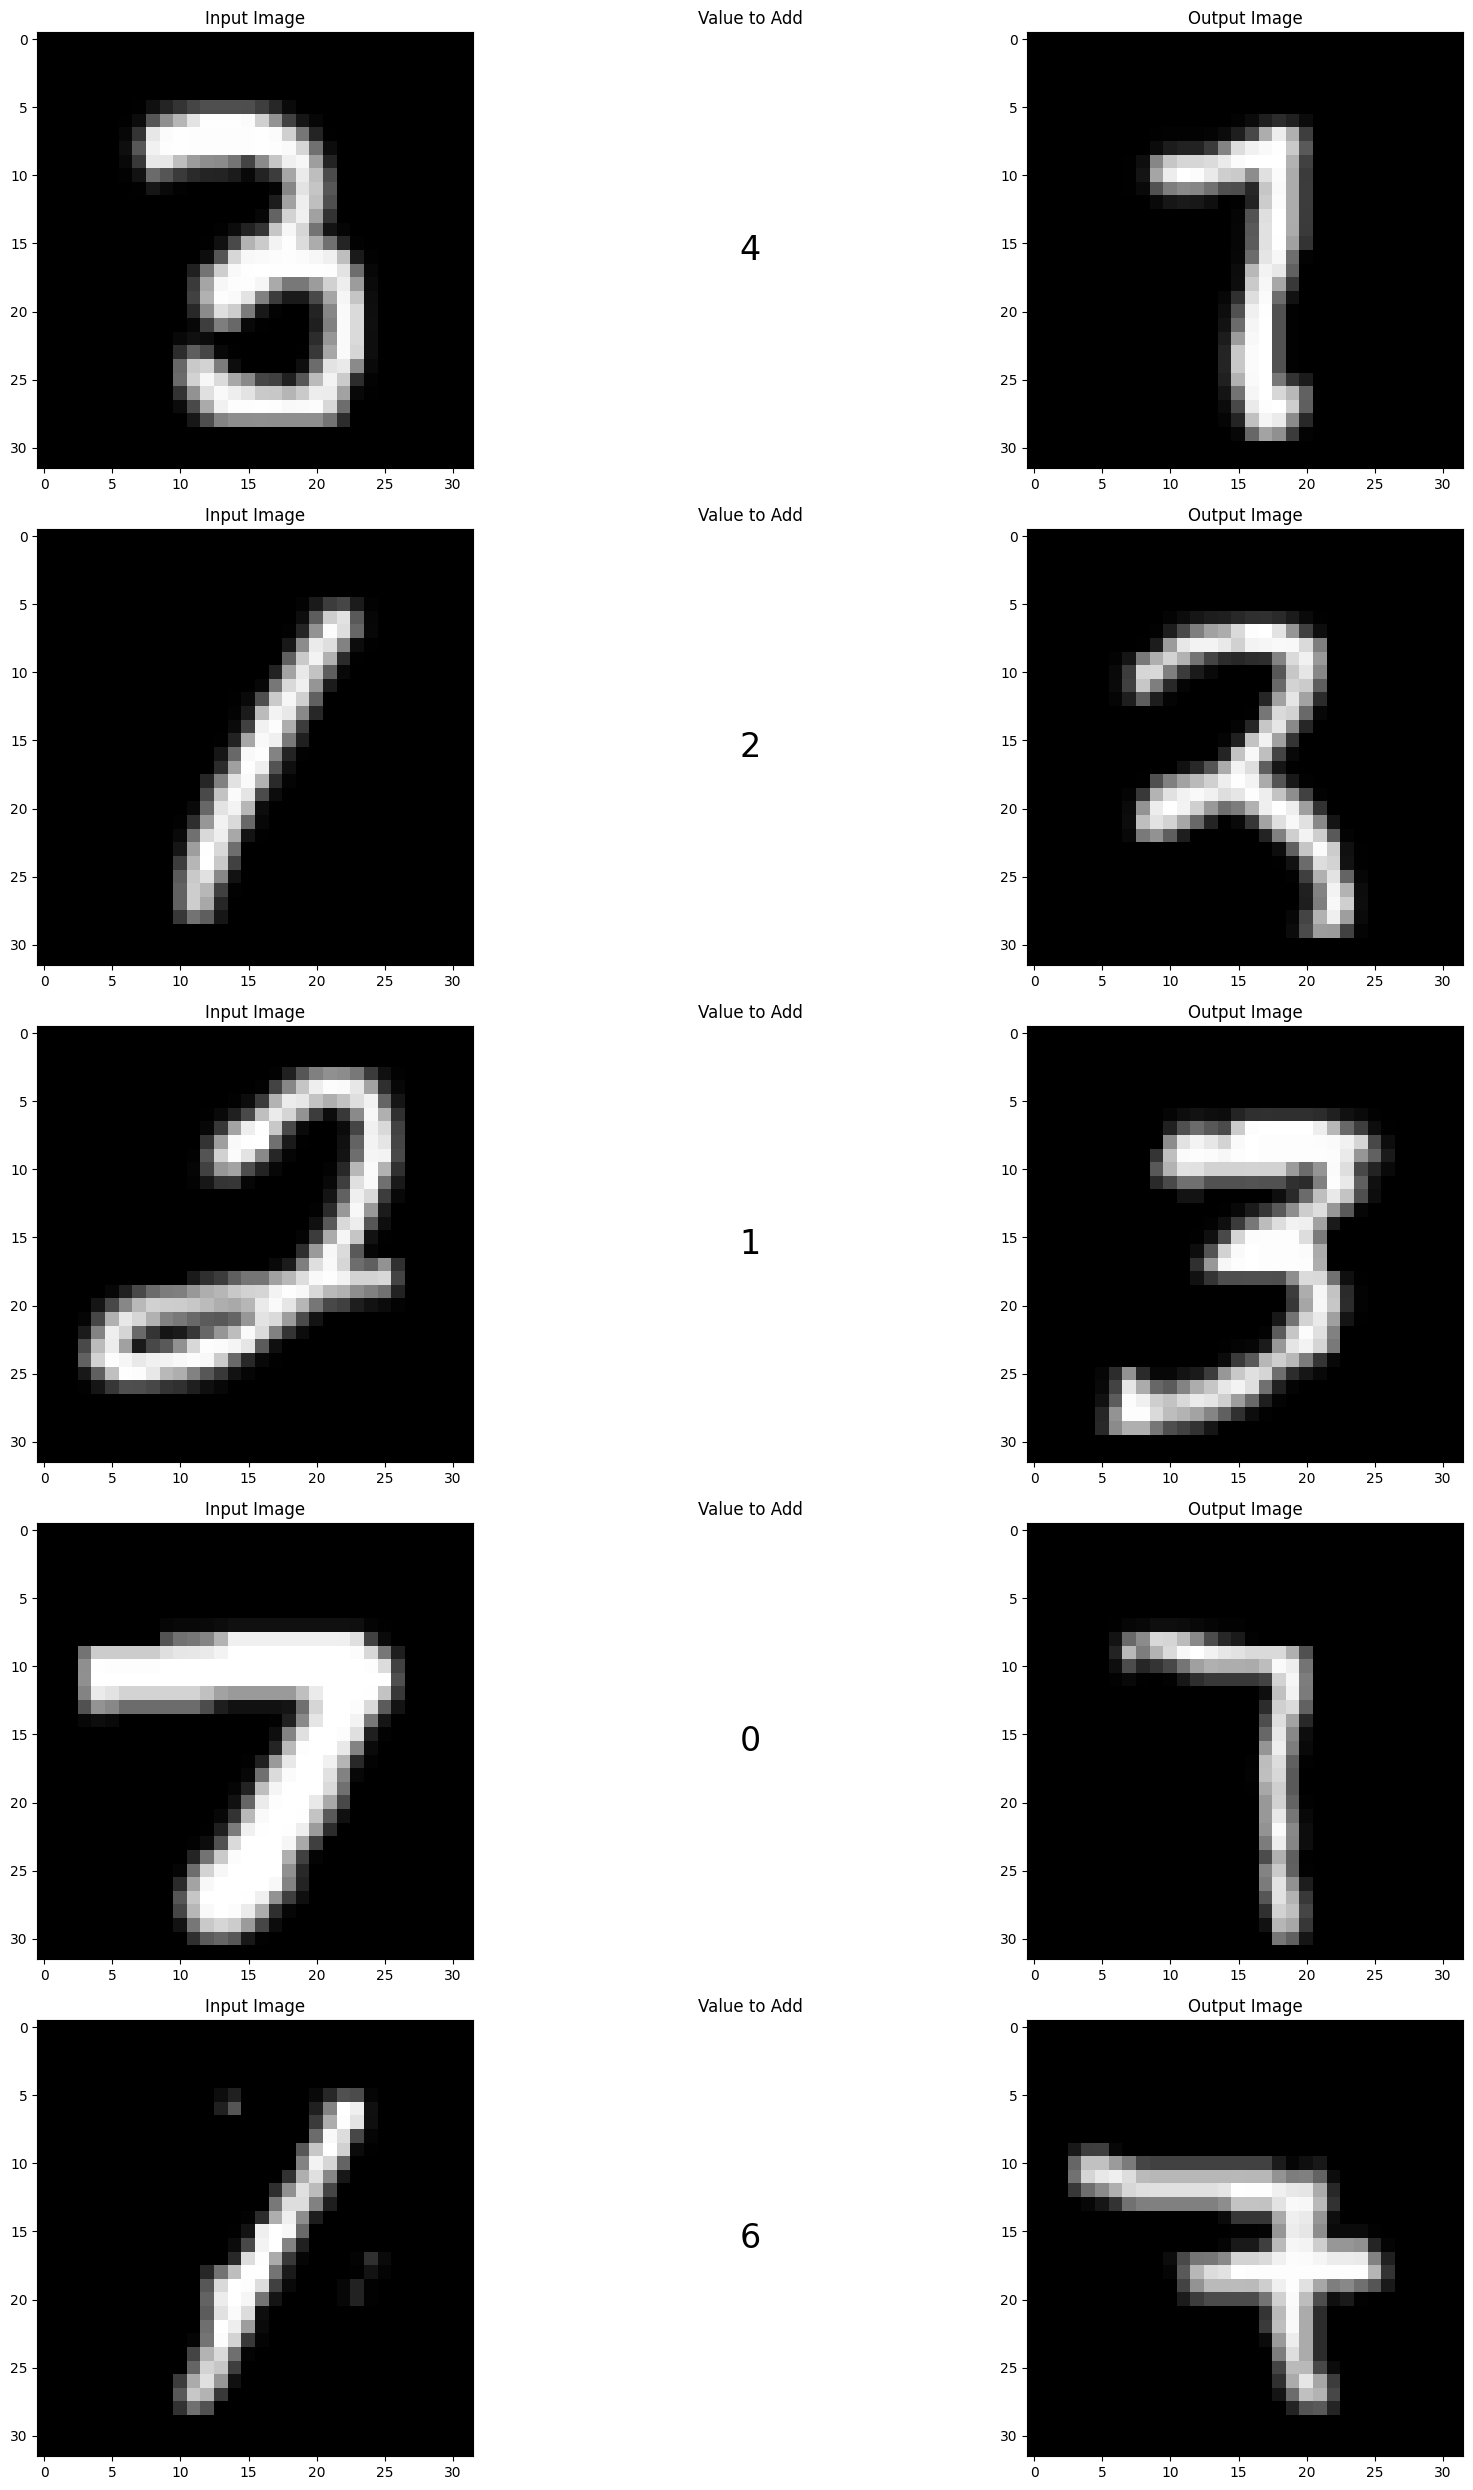

In [66]:
visualize_samples_(img_in, value_in, img_out)

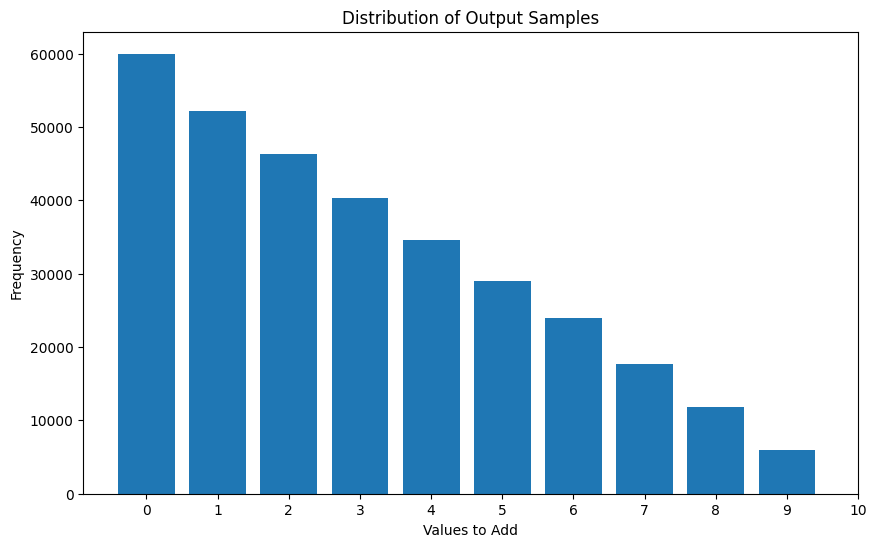

In [67]:
visualize_distribution_(value_in)

In [167]:
train_dataset_tra = TensorDataset(img_in, value_in, img_out)
val_dataset_tra = TensorDataset(img_in_val, value_in_val, img_out_val)

train_loader_tra = DataLoader(train_dataset_tra, batch_size=32, shuffle=True)
val_loader_tra = DataLoader(val_dataset_tra, batch_size=32, shuffle=False)

In [168]:
#Verificación de mis datos después de transformarlos
for images, _ ,_ in train_loader_tra:
    print("Mínimo valor en el lote:", images.min().item())
    print("Máximo valor en el lote:", images.max().item())
    print("Media del lote:", images.mean().item())
    print("Desviación estándar del lote:", images.std().item())
    break

Mínimo valor en el lote: 0.0
Máximo valor en el lote: 1.0
Media del lote: 0.1349494457244873
Desviación estándar del lote: 0.2920667827129364


In [170]:
print("Dimension after transformation (Training):", img_in.shape)
print("Dimension after transformation (Validation):", img_in_val.shape)

Dimension after transformation (Training): torch.Size([321802, 1, 32, 32])
Dimension after transformation (Validation): torch.Size([53454, 1, 32, 32])


In [171]:
x_train_d, y_train_d = train_dataset_tra.data, train_dataset_tra.targets
x_val_d, y_val_d = val_dataset_tra.data, val_dataset_tra.targets

AttributeError: 'TensorDataset' object has no attribute 'data'

After the transformation, our data loses the characteristics of data and targets. This is important to note when creating inferences with our trained model. For example, when we will see below and we want to extract the label of the image of a number in the function: "get_image_of_number"

__2. Following the depicted overview of the method, please implement the addition model. Your model should receive as inputs the code provided by the encoder (zk) and the number to be added (uk) and should output a code of the resulting number zp(k+1) (that will be used later by the decoder to display). Create your model with the following specs:__

__• MLP (32), ReLU__ 

__• MLP (16), ReLU__

__• MLP (16), ReLU__

__• MLP (7), Linear__

In [41]:
class Adder(nn.Module):
    def __init__(self):
        super(Adder, self).__init__()
        self.fc1 = nn.Linear(7 + 1, 32)  # 7 from encoder and 1 for number to add
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 7)

    def forward(self, z_k, u_k):
        x = torch.cat((z_k, u_k), dim=1) 
        #print(f"Adder Concatenated Shape: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #print(f"Adder Output Shape: {x.shape}")
        return x

__3. Now plug all the models together (following the scheme shown in the overview), taking
care of instantiating the encoder and decoder twice (with shared weights between each
instance). Your full training model should receive one image and the number to add,
and provide two output images: the reconstruction of the input image and the expected
output image from the addition.__

In [42]:
class CompleteModel(nn.Module):
    def __init__(self, encoder, adder, decoder):
        super(CompleteModel, self).__init__()
        self.encoder = encoder
        self.adder = adder
        self.decoder = decoder

    def forward(self, x, num_to_add):
        z_k = self.encoder(x)
        u_k = num_to_add.view(-1, 1).float()
        z_p_k_plus_1 = self.adder(z_k, u_k)
        reconstructed_x = self.decoder(z_k)
        sum_x = self.decoder(z_p_k_plus_1)
        return reconstructed_x, sum_x

__4. Implement your training model loss, which is now the combination of three terms: i) Two reconstruction terms, one for the L2 error between the input encoding (as done in the previous item) and one L2 reconstruction loss between the generated number by your model and the expected one. Please use a scaling of 0.1 for the reconstruction of the input in the loss.; ii) and a L2 reconstruction error between the codes generated by the addition model and the code resulting from the encoder of the output image (which is the one provided in the training sample). This term is to enforce the code to be similar.__

In [44]:
criterion_mse = nn.MSELoss()

def loss_function(reconstructed_img, original_img, added_img, expected_added_img, code, added_code):  
    L2_orig = criterion_mse(reconstructed_img, original_img)
    L2_added = criterion_mse(added_img, expected_added_img)
    L2_code = criterion_mse(code, added_code)
    return L2_orig * 0.1 + L2_added + L2_code

In [45]:
# Verificación de las dimensiones de los datos en train_loader_tra
for img_in_batch, value_in_batch,img_out_batch in train_loader_tra:
    print("Dimensiones de img_in_batch:", img_in_batch.shape)
    print("Dimensiones de img_out_batch:", img_out_batch.shape)
    print("Dimensiones de value_in_batch:", value_in_batch.shape)
    break  #


Dimensiones de img_in_batch: torch.Size([32, 1, 32, 32])
Dimensiones de img_out_batch: torch.Size([32, 1, 32, 32])
Dimensiones de value_in_batch: torch.Size([32])


__5. Train your complete training model for 100 epochs using Adam with a learning rate of
0.001. Use as an evaluation metric the L2 reconstruction error between the expected
added image and the one provided by the model.__

In [46]:
def train(epoch,writer):
    model.train()
    train_loss = 0
    for batch_idx, (img_in_batch, value_in_batch, img_out_batch) in enumerate(train_loader_tra):
        
        img_in_batch = img_in_batch.to(device)
        value_in_batch = value_in_batch.to(device)
        img_out_batch = img_out_batch.to(device)

        optimizer.zero_grad()
        num_to_add = value_in_batch.float().unsqueeze(1)

        reconstructed_img, added_img = model(img_in_batch, num_to_add)
        code = encoder(img_in_batch)
        added_code = encoder(added_img)  # Aquí se calcula added_code
        loss = loss_function(reconstructed_img, img_in_batch, added_img, img_out_batch, code, added_code)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx == 0:  
            n_images = 5  
            img_grid_input = torchvision.utils.make_grid(img_in_batch[:n_images].cpu(), nrow=5)
            img_grid_output = torchvision.utils.make_grid(added_img[:n_images].cpu(), nrow=5)
            img_grid_target = torchvision.utils.make_grid(img_out_batch[:n_images].cpu(), nrow=5)
            writer.add_image('Epoch_{}_Input'.format(epoch), img_grid_input, epoch)
            writer.add_image('Epoch_{}_Generated'.format(epoch), img_grid_output, epoch)
            writer.add_image('Epoch_{}_Target'.format(epoch), img_grid_target, epoch)

            # Mostrar los valores sumados
            values_to_add = value_in_batch[:n_images].view(-1).cpu().numpy()
            values_text = "Values to Add: " + ', '.join(map(str, values_to_add))
            writer.add_text('Epoch_{}_Values'.format(epoch), values_text, epoch)

    avg_train_loss = train_loss / len(train_loader_tra.dataset)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    return avg_train_loss

def test(epoch,writer):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (img_in_batch, value_in_batch, img_out_batch) in enumerate(val_loader_tra):
            img_in_batch = img_in_batch.to(device)
            value_in_batch = value_in_batch.to(device)
            img_out_batch = img_out_batch.to(device)

            num_to_add = value_in_batch.float().unsqueeze(1)

            reconstructed_img, added_img = model(img_in_batch, num_to_add)
            code = encoder(img_in_batch)
            added_code = encoder(added_img)  # Aquí se calcula added_code
            loss = loss_function(reconstructed_img, img_in_batch, added_img, img_out_batch, code, added_code)
            
            test_loss += loss.item()

    avg_test_loss = test_loss / len(val_loader_tra.dataset)
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    return avg_test_loss

In [47]:
encoder = Encoder()
decoder = DecoderConvTranspose()
adder = Adder()
model = CompleteModel(encoder, adder, decoder).to(device)
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
#check_encoder_output(encoder, train_loader_tra)

In [29]:
writer = SummaryWriter()#modelinpio.pth
save_path = r'C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\modelinpio.pth'

num_epochs=100
best_test_loss = float('inf')
best_model_state = None

for epoch in range(1, num_epochs+1):
    avg_train_loss = train(epoch,writer)
    avg_test_loss = test(epoch,writer)

    print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_test_loss:.4f}')
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = model.state_dict().copy()  # Guardadito
        torch.save(best_model_state, save_path)
        print(f"Model checkpoint saved at {save_path}")

writer.close()

Epoch 1: Train Loss: 0.0018, Validation Loss: 0.0016
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_balanced.pth
Epoch 2: Train Loss: 0.0016, Validation Loss: 0.0016
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_balanced.pth
Epoch 3: Train Loss: 0.0015, Validation Loss: 0.0015
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_balanced.pth
Epoch 4: Train Loss: 0.0015, Validation Loss: 0.0015
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_balanced.pth
Epoch 5: Train Loss: 0.0015, Validation Loss: 0.0015
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_balanced.pth
Epoch 6: Train Loss: 0.0015, Validation Loss: 0.0014
Mo

Epoch 95: Train Loss: 0.0014, Validation Loss: 0.0014
Epoch 96: Train Loss: 0.0014, Validation Loss: 0.0014
Epoch 97: Train Loss: 0.0014, Validation Loss: 0.0014
Epoch 98: Train Loss: 0.0014, Validation Loss: 0.0014
Epoch 99: Train Loss: 0.0014, Validation Loss: 0.0014
Epoch 100: Train Loss: 0.0014, Validation Loss: 0.0014


 __Was our model affected by overfitting?__
 
 In the TensorBoard-generated graphs, there is a decreasing loss for both the test and training sets. This suggests no evident signs of overfitting, as typically indicated by the test loss diverging and increasing while the training loss continues to decrease, which is not observed here.

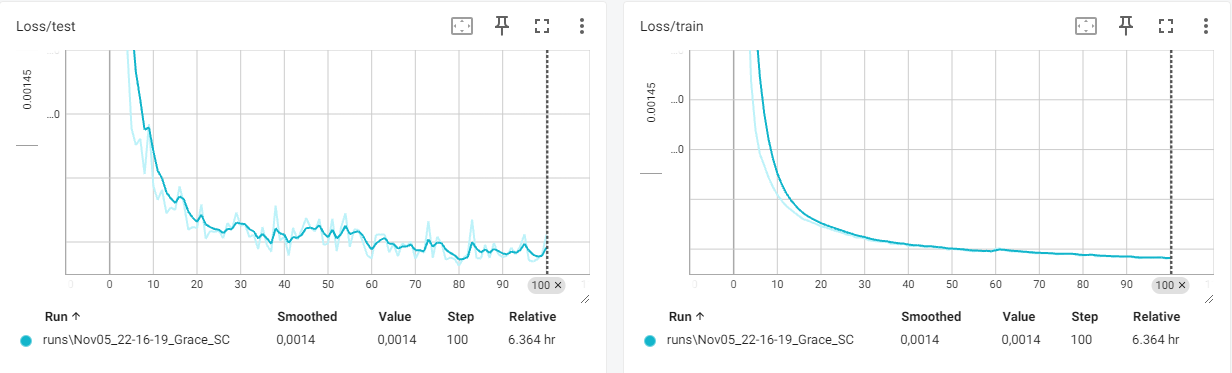

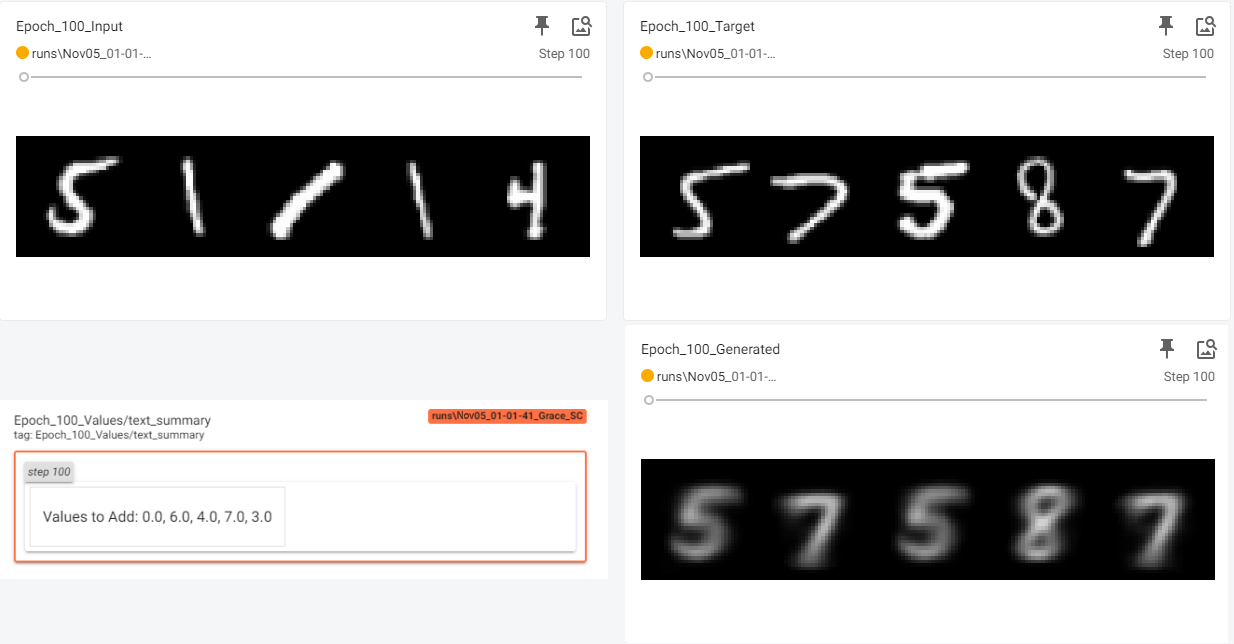

In [48]:
load_path = r'C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\modelinpio.pth'
model = CompleteModel(encoder, adder, decoder).to(device)
model.load_state_dict(torch.load(load_path))
model.eval()

CompleteModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (fc1): Linear(in_features=2048, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=7, bias=True)
  )
  (adder): Adder(
    (fc1): Linear(in_features=8, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=16, bias=True)
    (fc4): Linear(in_features=16, out_features=7, bias=True)
  )
  (decoder): DecoderConvTranspose(
    (fc1): Linear(in_features=7, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=2048, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), paddin

__6. Create an inference/test model using the learned encoder, decoder, and model addition
submodels (that is only solid line modules should remain in the test as shown in the
overview image). Your inference model should output only the expected number images
of the addition. Use your inference model to generate the following visualization for some
possible variations of the input images and numbers to be added. We provide an initial
pseudocode for this visualization__

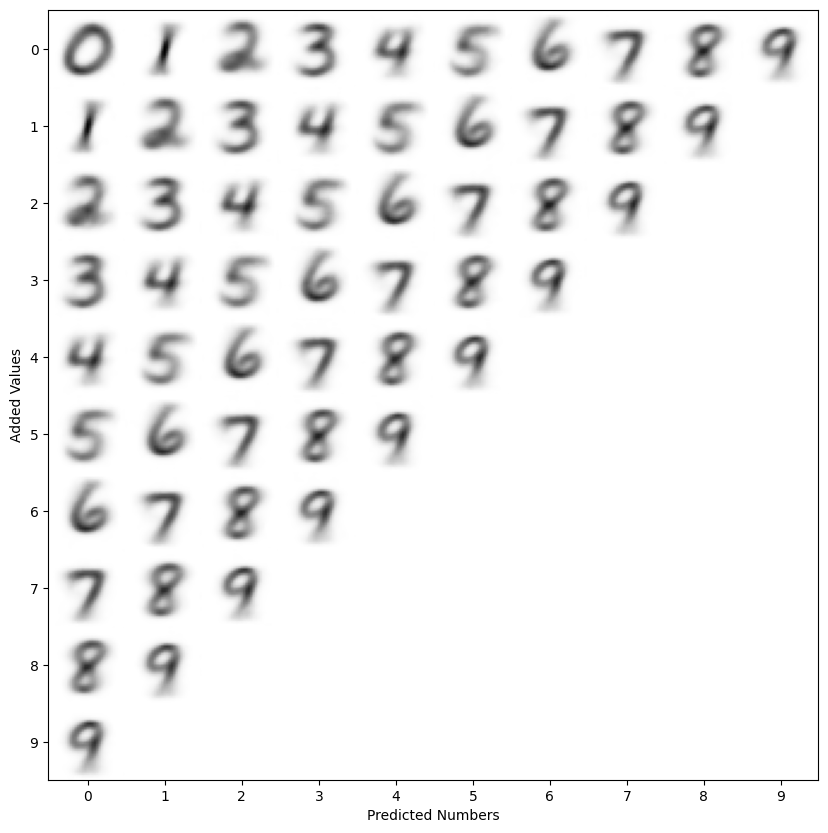

In [49]:
def get_image_of_number(number, dataloader):
    for images, labels in dataloader:
        for i, label in enumerate(labels):
            if label.item() == number:
                return transforms.Resize((32, 32), antialias=True)(images[i].unsqueeze(0)).to(device)
    raise ValueError(f"No image found for number: {number}")

def prediction(model, img_test_true, number):
    number_tensor = torch.tensor([number], dtype=torch.float32, device=device).unsqueeze(1)
    with torch.no_grad():
        model.eval()
        _, predicted_sum_image = model(img_test_true, number_tensor)
        return predicted_sum_image.squeeze(0).cpu().numpy()

def prediction_different_numbers(digit, model, dataloader, img_size):
    max_value = 9  
    predicted_images = []
    img_test_true = get_image_of_number(digit, dataloader)
    for number_to_add in range(max_value + 1):  # We range to max_value + 1 to include the 0 addition
        if digit + number_to_add <= max_value:
            img_out = prediction(model, img_test_true, number_to_add)
            img_out_reshaped = img_out.reshape(img_size)
            img_out_inverted = 1 - img_out_reshaped 
            predicted_images.append(img_out_inverted)
        else:
            predicted_images.append(np.ones(img_size))
    return np.concatenate(predicted_images, axis=0)

def display_images(model, dataloader, img_size):
    n = 10 
    digit_size = img_size[0]
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for index in range(n):
        images = prediction_different_numbers(index, model, dataloader, img_size)
        figure[:, index * digit_size: (index + 1) * digit_size] = images

    plt.figure(figsize=(n, n))
    plt.imshow(figure, cmap='Greys_r')
    plt.xticks(np.arange(digit_size / 2, digit_size * n, digit_size), np.arange(n))
    plt.yticks(np.arange(digit_size / 2, digit_size * n, digit_size), np.arange(n))
    plt.xlabel("Predicted Numbers")
    plt.ylabel("Added Values")
    plt.show()

img_size = (32, 32)
display_images(model, train_loader_, img_size)

__7. Finally, provide and visualize the generated output of your model to the following inputs:
(’image of 7’, 1), (’image of 7’, 2) and (’image of 7’, 1.5), (’image of 7’, 1.4), (’image of 7’,
1.6).__

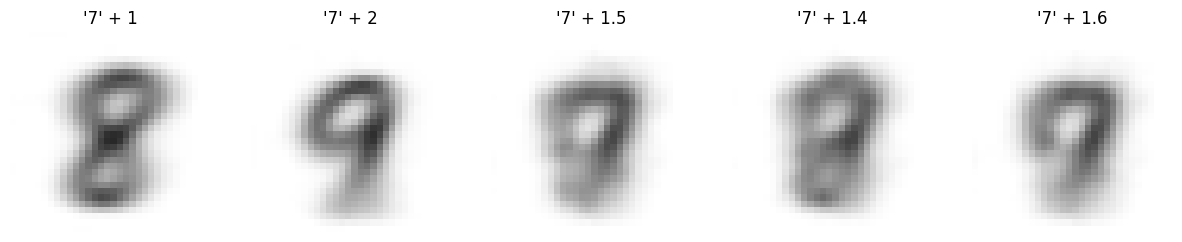

In [51]:
def visualize_model_output(model, dataloader, base_digit, additions, img_size):
    base_image = get_image_of_number(base_digit, dataloader)
    output_images = []
    
    for num in additions:
            output_image = prediction(model, base_image, num)
            output_images.append(output_image.reshape(img_size))

    fig, axes = plt.subplots(1, len(additions), figsize=(len(additions) * 3, 3))
    for i, (ax, img) in enumerate(zip(axes, output_images)):
        ax.imshow(1 - img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"'7' + {additions[i]}")
        ax.axis('off')  
    plt.show()

additions = [1, 2, 1.5, 1.4, 1.6]
img_size = (32, 32)
visualize_model_output(model, train_loader_, 7, additions, img_size)


__What can you observe?__

The inference tends to be wrong when adding numbers with decimals, and the model tries to show only the sum between the base number and the decimal integer. PS: When the decimal is equal to or greater than 0.5 the image is blurred but tends to resemble the image of the base number + decimal integer.

# Part IV - Addition with Generative Model

_Let’s turn this model into a generative one, such as that we now handle distributions and
generate new samples from it._

__1. Please perform the required changes in the architecture for the encoder-decoder of your previous model to be a variational autoencoder (make the appropriate changes also in the losses). Do not forget the “reparameterization trick” and the respective KL losses.__

#### Unbalanced data 

Because training was costing my model, as it was generating pure fuzzy nines (9), one of the strategies I did was to balance my train and validation data. In the report I have extended my explanation.

In [172]:
# Classes distribution after transformation
from collections import Counter
value_counts = Counter(value_in.numpy())
print("Distribución de clases después de transform_data_add:", value_counts)

Distribución de clases después de transform_data_add: Counter({0.0: 60000, 1.0: 52143, 2.0: 46380, 3.0: 40285, 4.0: 34575, 5.0: 28990, 6.0: 23983, 7.0: 17723, 8.0: 11800, 9.0: 5923})


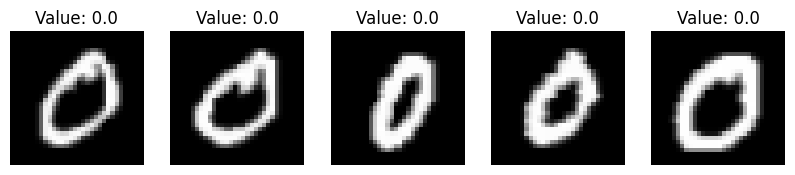

In [173]:
def show_transformed_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        ax = axes[i]
        img, val, _ = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Value: {val.item()}")
        ax.axis('off')
    plt.show()

#showing images 
show_transformed_images(train_dataset_tra)


In [174]:
#frecuencia de clases en los primeros N lotes
N=10
class_counts_batches = Counter()
for images, values, _ in islice(train_loader_tra, N):
    class_counts_batches.update(values.numpy())

print("Distribución de clases en los primeros N lotes de train_loader_tra:", class_counts_batches)

Distribución de clases en los primeros N lotes de train_loader_tra: Counter({1.0: 66, 0.0: 54, 2.0: 52, 4.0: 38, 3.0: 37, 5.0: 26, 7.0: 16, 6.0: 15, 8.0: 10, 9.0: 6})


In [175]:
# Transformando los datos de prueba
img_in_val, value_in_val, img_out_val = transform_data_add(x_val_, y_val_)

# Counting classes in test data
value_counts_test = Counter(value_in_val.numpy())
print("Distribución de clases en los datos de prueba:", value_counts_test)

Distribution of values: [[980], [980, 1135], [980, 1032, 1032], [980, 1010, 1010, 1010], [980, 982, 982, 982, 982], [892, 892, 892, 892, 892, 892], [958, 958, 958, 958, 958, 892, 958], [980, 1028, 1028, 1010, 982, 892, 958, 1028], [974, 974, 974, 974, 974, 892, 958, 974, 974], [980, 1009, 1009, 1009, 982, 892, 958, 1009, 974, 1009]]
Values to add: [0. 0. 0. ... 0. 0. 0.]
Distribución de clases en los datos de prueba: Counter({0.0: 10000, 1.0: 8694, 2.0: 7681, 3.0: 6644, 4.0: 5706, 5.0: 4834, 6.0: 3969, 7.0: 2963, 8.0: 1983, 9.0: 980})


In [176]:
N=1000
class_counts_batches = Counter()
for images, values, _ in islice(val_loader_tra, N): # N lotes que quiero revisar
    class_counts_batches.update(values.numpy())

print("Classes distribution in the first N lotes de val_loader_tra:", class_counts_batches)

Classes distribution in the first N lotes de val_loader_tra: Counter({0.0: 6989, 1.0: 5788, 2.0: 4822, 3.0: 4717, 4.0: 3840, 5.0: 2878, 6.0: 1986, 7.0: 980})


In [177]:
def transform_data_addVAE(x_train, y_train, img_size=[32, 32], target_range=10):
    x_train_np = x_train.cpu().numpy()
    y_train_np = y_train.cpu().numpy()

    img_in, img_out, value_in = [], [], []

    for i in range(target_range):
        for j in range(target_range):
            if i + j < target_range:
                indices_i = np.where(y_train_np == i)[0]
                indices_sum = np.where(y_train_np == (i + j))[0]
                min_len = min(len(indices_i), len(indices_sum))

                selected_indices_i = indices_i[:min_len]
                selected_indices_sum = indices_sum[:min_len]

                img_in.extend(x_train_np[selected_indices_i])
                img_out.extend(x_train_np[selected_indices_sum])
                value_in.extend([j] * min_len)

    img_in = [cv.resize(item, tuple(img_size)) for item in img_in]
    img_out = [cv.resize(item, tuple(img_size)) for item in img_out]
    
    img_in = np.array(img_in) / 255.0
    img_out = np.array(img_out) / 255.0
    
    img_in = torch.Tensor(img_in).unsqueeze(1)
    img_out = torch.Tensor(img_out).unsqueeze(1)
    value_in = torch.Tensor(value_in)

    return img_in, value_in, img_out

In [178]:
img_inVAE, value_inVAE, img_outVAE = transform_data_addVAE(x_train_, y_train_)
img_in_valVAE, value_in_valVAE, img_out_valVAE = transform_data_addVAE(x_val_, y_val_)

In [179]:
def calculate_class_weights(y_train):
    class_counts = Counter(y_train.numpy())
    total = sum(class_counts.values())
    class_weights = {cls: total/count for cls, count in class_counts.items()}
    weights = [class_weights[y.item()] for y in y_train]
    return torch.FloatTensor(weights)

In [180]:
#Class weights of values_in in train and val 
class_weights_t = calculate_class_weights(value_inVAE)
class_weights_v = calculate_class_weights(value_in_valVAE)
#muestreo ponderado
weighted_sampler_t = WeightedRandomSampler(class_weights_t, len(class_weights_t))
weighted_sampler_v = WeightedRandomSampler(class_weights_v, len(class_weights_v))

train_dataset_tra_v = TensorDataset(img_inVAE, value_inVAE, img_outVAE)
val_dataset_tra_v = TensorDataset(img_in_valVAE, value_in_valVAE, img_out_valVAE)

train_loader_tra_VAE = DataLoader(train_dataset_tra_v, batch_size=32, shuffle=False, sampler=weighted_sampler_t)
val_loader_tra_VAE = DataLoader(val_dataset_tra_v, batch_size=32, shuffle=False, sampler=weighted_sampler_v)

In [181]:
def count_classes(loader):
    counter = Counter()
    for _, values, _ in loader:
        counter.update(values.numpy())
    return counter

# Counting classes in the train_loader_tra_VAE
class_distribution_train = count_classes(train_loader_tra_VAE)
print("Distribución de clases en train_loader_tra_VAE:", class_distribution_train)

# Counting classes in the val_loader_tra_VAE
class_distribution_val = count_classes(val_loader_tra_VAE)
print("Distribución de clases en val_loader_tra_VAE:", class_distribution_val)

Distribución de clases en train_loader_tra_VAE: Counter({1.0: 32440, 0.0: 32325, 5.0: 32315, 4.0: 32282, 3.0: 32167, 7.0: 32161, 8.0: 32148, 2.0: 32064, 6.0: 32062, 9.0: 31838})
Distribución de clases en val_loader_tra_VAE: Counter({2.0: 5440, 7.0: 5432, 8.0: 5390, 4.0: 5380, 6.0: 5350, 9.0: 5335, 3.0: 5331, 0.0: 5284, 5.0: 5278, 1.0: 5234})


In [27]:
def visualize_samples_vae(img_in_, value_in_, img_out_, num_samples=5):
    indices = random.sample(range(len(img_in_)), num_samples)
    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices):
        # Mostrando imagen de entrada
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_in_[idx][0].numpy(), cmap="gray")
        plt.title("Input Image")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.text(0.5, 0.5, f'+ {int(value_in_[idx].item())}', fontsize=24, ha='center')
        plt.title("Value to Add")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(img_out_[idx][0].numpy(), cmap="gray")
        plt.title("Output Image")

    plt.tight_layout()
    plt.show()

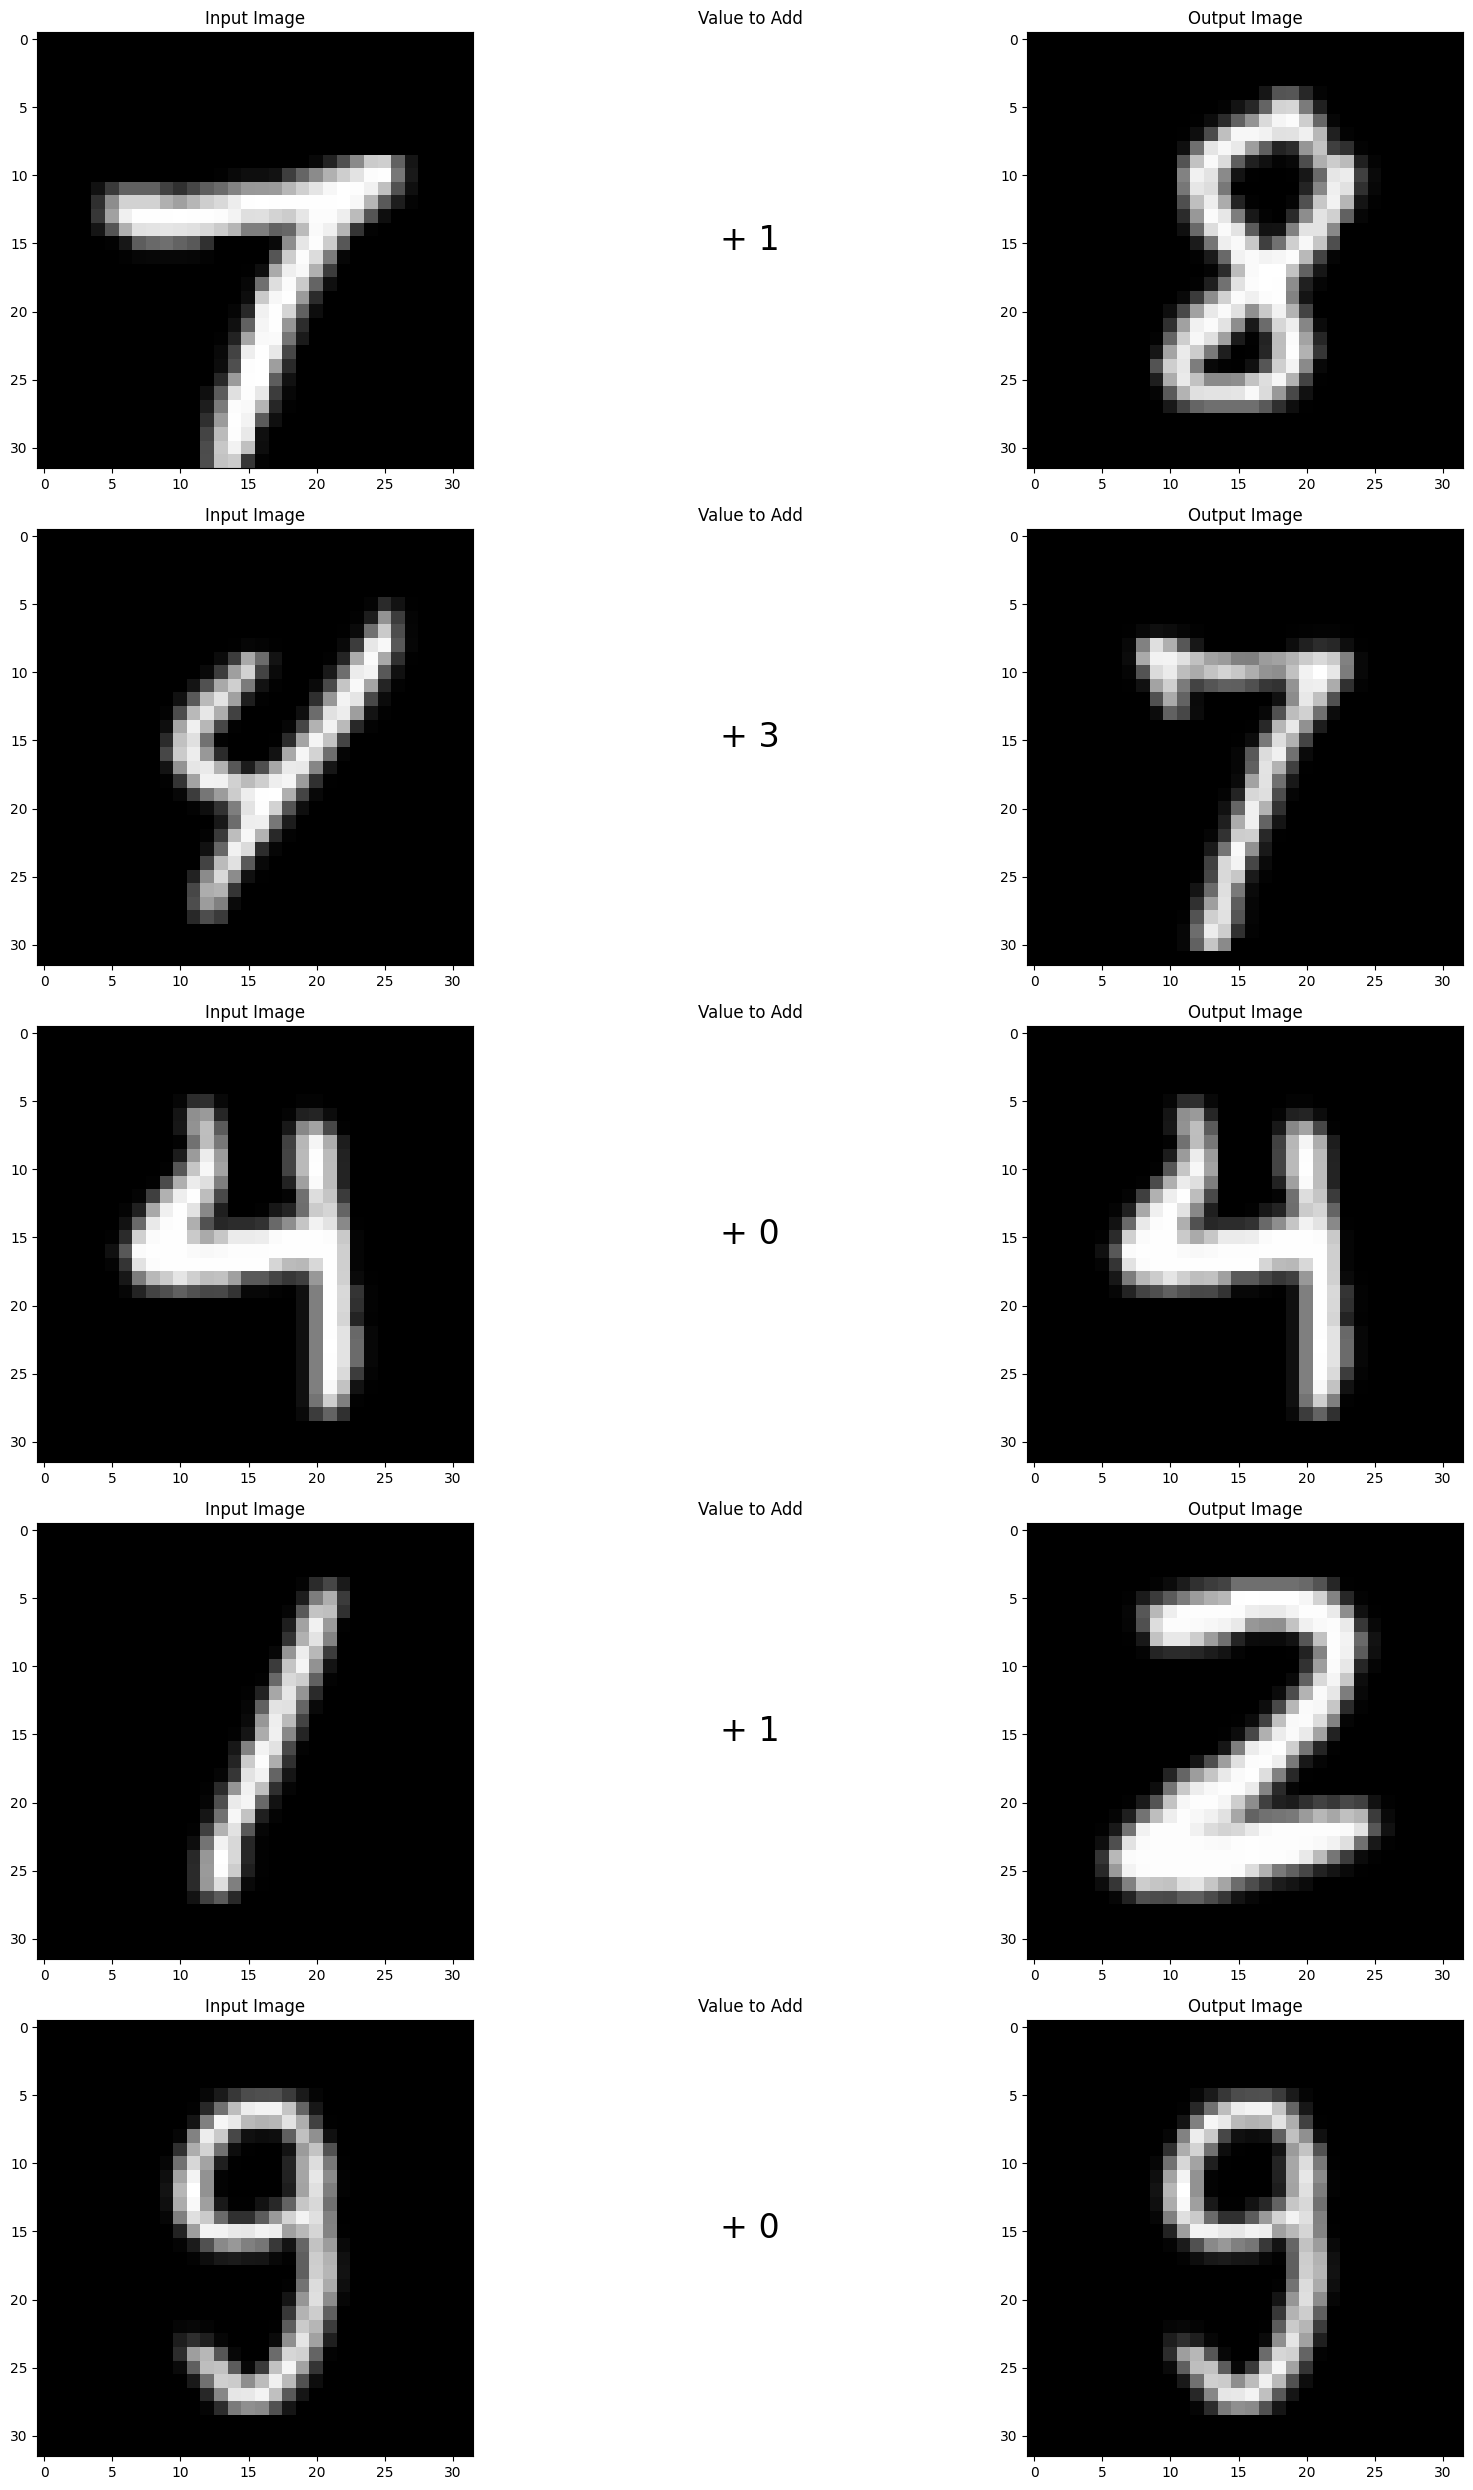

In [28]:
visualize_samples_vae(img_inVAE, value_inVAE, img_outVAE)

#### Continued VAE changes ...

In [182]:
for images, _, _ in train_loader_tra_VAE:
    print("Mínimo valor en el lote:", images.min().item())
    print("Máximo valor en el lote:", images.max().item())
    print("Media del lote:", images.mean().item())
    print("Desviación estándar del lote:", images.std().item())
    break

Mínimo valor en el lote: 0.0
Máximo valor en el lote: 1.0
Media del lote: 0.14157356321811676
Desviación estándar del lote: 0.30272987484931946


In [183]:
class VAE_Encoder(nn.Module): #(Modified Encoder)
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=256)
        # I changed the last linear layer to produce means and log-variances.        
        self.fc_mu = nn.Linear(in_features=256, out_features=50)
        self.fc_log_var = nn.Linear(in_features=256, out_features=50)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        # medias y log-varianzas
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

In [184]:
class DecoderConvTransposeVAE(nn.Module):
    def __init__(self):
        super(DecoderConvTransposeVAE, self).__init__()
        self.fc1 = nn.Linear(50, 256)
        self.fc2 = nn.Linear(256, 128 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # Tamaño después: 14x14
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # Tamaño después: 28x28
        self.deconv3 = nn.ConvTranspose2d(32, 1, 7, stride=1, padding=1) 

    def forward(self, x):        
        #print(f"Decoder Input Shape: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        #print(f"Decoder Reshaped Shape: {x.shape}")
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        #print(f"Decoder Output Shape: {x.shape}")
        return x

In [185]:
class AdderVAE(nn.Module):
    def __init__(self):
        super(AdderVAE, self).__init__()
        self.fc1 = nn.Linear(50 + 50, 32)  
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 50)

    def forward(self, z_k, u_k):
        x = torch.cat((z_k, u_k), dim=1) 
        #print(f"Adder Concatenated Shape: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #print(f"Adder Output Shape: {x.shape}")
        return x

I want to make a small comment here , even though I was training with transformed and balanced data , unfortunately my model only kept generating fuzzy nines (9) , that is why the existence of this function , ValueToLatent , which converts the value added to a latent space that can be handled in the CompleteModel function but this time with the VAE components.

In [186]:
class ValueToLatent(nn.Module):
    def __init__(self, input_dim, latent_dim=50):
        super(ValueToLatent, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, latent_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [187]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class CompleteModelVAE(nn.Module):
    def __init__(self, encoder, adder, decoder, value_to_latent):
        super(CompleteModelVAE, self).__init__()
        self.encoder = encoder
        self.adder = adder
        self.decoder = decoder
        self.value_to_latent = value_to_latent
    
    def forward(self, x, num_to_add):
        mu, log_var = self.encoder(x)
        z_k = reparameterize(mu, log_var)
        u_k_latent = self.value_to_latent(num_to_add.view(-1, 1).float())
        z_p_k_plus_1 = self.adder(z_k, u_k_latent)
        reconstructed_x = self.decoder(z_k)
        sum_x = self.decoder(z_p_k_plus_1)
        return reconstructed_x, sum_x, mu, log_var       

In [188]:
criterion_mse = nn.MSELoss()

def loss_function_VAE(reconstructed_img, original_img, added_img, expected_added_img, mu, log_var):
    L2_orig = criterion_mse(reconstructed_img, original_img)
    L2_added = criterion_mse(added_img, expected_added_img)
    kld_weight = 0.0001  # Reduci
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return L2_orig + L2_added + kld_weight * kld_loss

__2. Please re-train your variational model and perform the inference again for the following inputs : (’image of 7’, 1), (’image of 7’, 2) and (’image of 7’, 1.5), (’image of 7’, 1.4), (’image of 7’, 1.6). Compare the generated results with the previous model in Part III. What can you observe?__

In [189]:
def train(epoch, writer,model, train_loader_tra_VAE, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (img_in_batch, value_in_batch, img_out_batch) in enumerate(train_loader_tra_VAE):
        img_in_batch, value_in_batch, img_out_batch = img_in_batch.to(device), value_in_batch.to(device), img_out_batch.to(device)
        
        optimizer.zero_grad()
        num_to_add = value_in_batch.float().unsqueeze(1)

        reconstructed_img, added_img, mu, logvar = model(img_in_batch, num_to_add)
        loss = loss_function_VAE(reconstructed_img, img_in_batch, added_img, img_out_batch, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx == 0:  # Solo para el primer lote sino muy pesado
            n_images = 5
            img_grid_input = torchvision.utils.make_grid(img_in_batch[:n_images].cpu(), nrow=5)
            img_grid_output = torchvision.utils.make_grid(added_img[:n_images].cpu(), nrow=5)
            img_grid_target = torchvision.utils.make_grid(img_out_batch[:n_images].cpu(), nrow=5)
            
            writer.add_image('Epoch_{}_Input'.format(epoch), img_grid_input, epoch)
            writer.add_image('Epoch_{}_Generated'.format(epoch), img_grid_output, epoch)
            writer.add_image('Epoch_{}_Target'.format(epoch), img_grid_target, epoch)

            values_to_add = value_in_batch[:n_images].view(-1).cpu().numpy()
            values_text = "Values to Add: " + ', '.join(map(str, values_to_add))
            writer.add_text('Epoch_{}_Values'.format(epoch), values_text, epoch)

    avg_train_loss = train_loss / len(train_loader_tra_VAE.dataset)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    return avg_train_loss

def test(epoch, writer, model,val_loader_tra_VAE):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (img_in_batch, value_in_batch, img_out_batch) in enumerate(val_loader_tra_VAE):
            img_in_batch, value_in_batch, img_out_batch = img_in_batch.to(device), value_in_batch.to(device), img_out_batch.to(device)
            num_to_add = value_in_batch.float().unsqueeze(1)

            reconstructed_img, added_img, mu, logvar = model(img_in_batch, num_to_add)
            loss = loss_function_VAE(reconstructed_img, img_in_batch, added_img, img_out_batch, mu, logvar)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(val_loader_tra_VAE.dataset)
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    return avg_test_loss

In [190]:
encoder = VAE_Encoder().to(device)
decoder = DecoderConvTransposeVAE().to(device)
adder = AdderVAE().to(device)
value_to_latent = ValueToLatent(input_dim=1, latent_dim=50).to(device)
model_VAE = CompleteModelVAE(encoder, adder, decoder, value_to_latent).to(device)
optimizer = optim.Adam(model_VAE.parameters(),lr=0.001)


In [449]:
writer = SummaryWriter()
save_path = r'C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAE_cambiado_num.pth'

num_epochs=100
best_test_loss = float('inf')
best_model_state = None

for epoch in range(1, num_epochs+1):
    avg_train_loss = train(epoch, writer, model_VAE, train_loader_tra_VAE, optimizer)
    avg_test_loss = test(epoch, writer, model_VAE, val_loader_tra_VAE)

    print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_test_loss:.4f}')
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = model_VAE.state_dict().copy()  # Guardadito
        torch.save(best_model_state, save_path)
        print(f"Model checkpoint saved at {save_path}")

writer.close()

Epoch 1: Train Loss: 0.0030, Validation Loss: 0.0028
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAE_cambiado_num.pth
Epoch 2: Train Loss: 0.0027, Validation Loss: 0.0027
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAE_cambiado_num.pth
Epoch 3: Train Loss: 0.0027, Validation Loss: 0.0027
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAE_cambiado_num.pth
Epoch 4: Train Loss: 0.0027, Validation Loss: 0.0026
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAE_cambiado_num.pth
Epoch 5: Train Loss: 0.0026, Validation Loss: 0.0026
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAE_cambiado_num.pth
Epoch 6: Train 

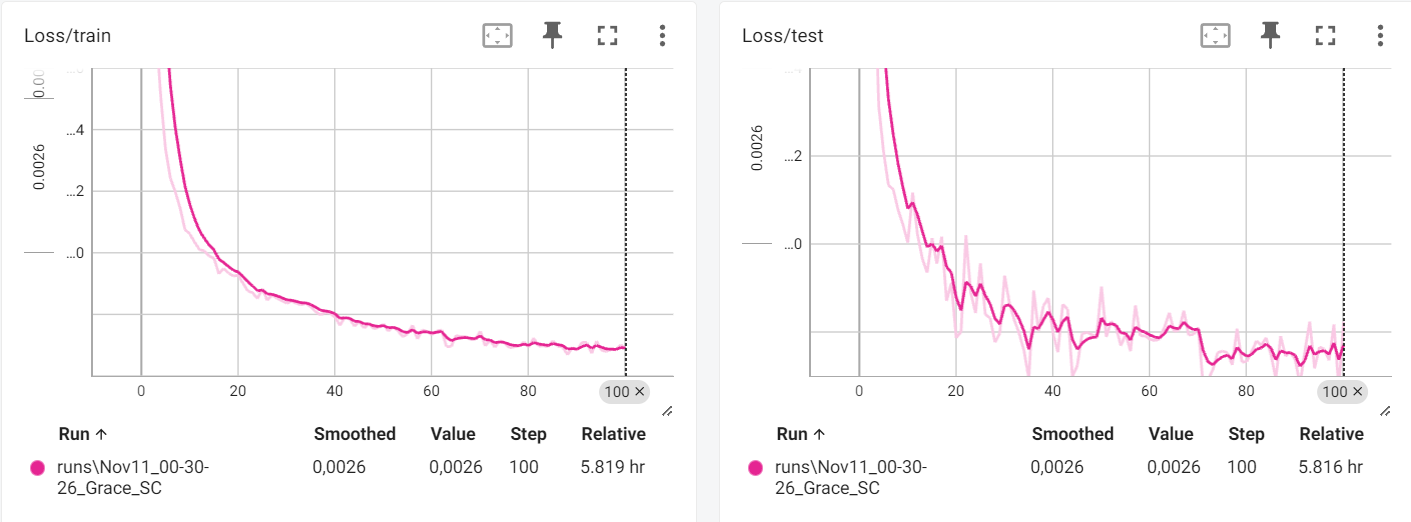

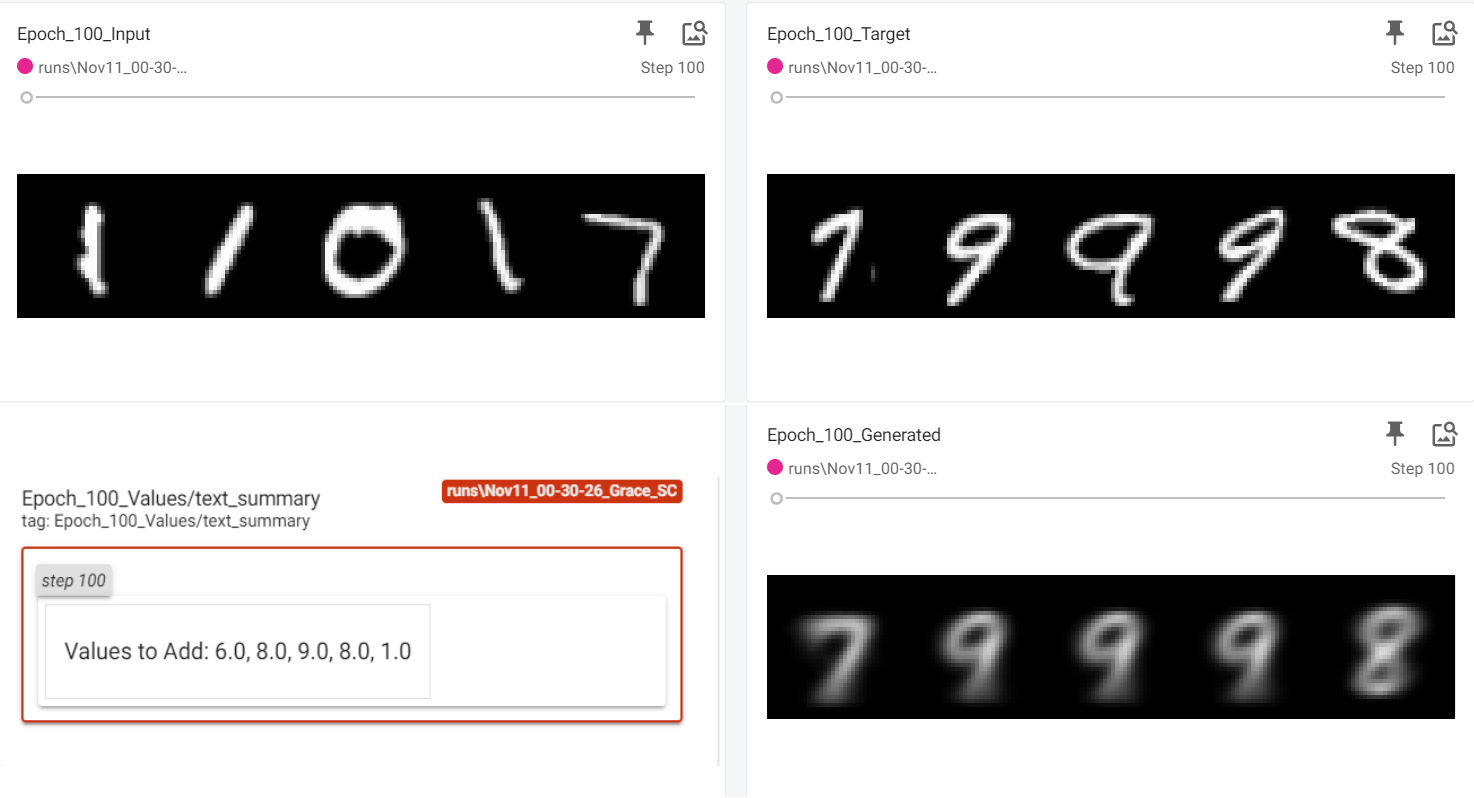

In [191]:
load_path = r'C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAE_cambiado_num.pth'
model_VAE = CompleteModelVAE(VAE_Encoder(),AdderVAE(),DecoderConvTransposeVAE(),value_to_latent).to(device)
model_VAE.load_state_dict(torch.load(load_path))
model_VAE.eval()

CompleteModelVAE(
  (encoder): VAE_Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (fc1): Linear(in_features=2048, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=50, bias=True)
    (fc_log_var): Linear(in_features=256, out_features=50, bias=True)
  )
  (adder): AdderVAE(
    (fc1): Linear(in_features=100, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=16, bias=True)
    (fc4): Linear(in_features=16, out_features=50, bias=True)
  )
  (decoder): DecoderConvTransposeVAE(
    (fc1): Linear(in_features=50, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=6272, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), paddin

In [192]:
def prediction_VAE(model, img_test_true, number):
    img_test_true = img_test_true.to(device)
    number_tensor = torch.tensor([number], dtype=torch.float32).to(device)

    with torch.no_grad():
        model.eval()
        _, predicted_sum_image, _, _ = model(img_test_true, number_tensor)
        return predicted_sum_image.squeeze(0).cpu().numpy()

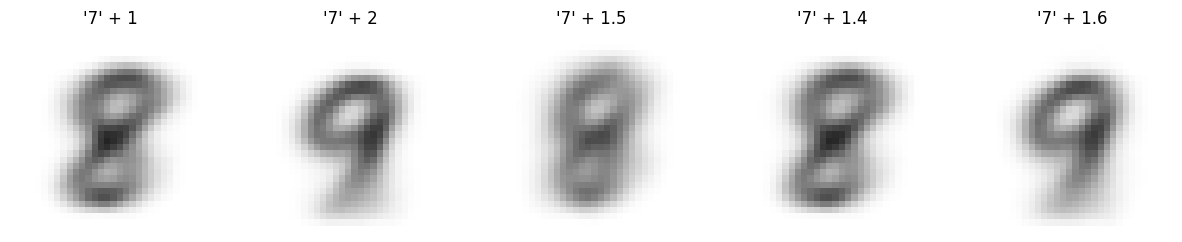

In [194]:
def visualize_model_output(model, dataloader, base_digit, additions, img_size):
    base_image = get_image_of_number(base_digit, dataloader)
    output_images = []
    
    for num in additions:
        output_image = prediction_VAE(model, base_image, num)
        output_images.append(output_image.reshape(img_size))

    fig, axes = plt.subplots(1, len(additions), figsize=(len(additions) * 3, 3))
    for i, (ax, img) in enumerate(zip(axes, output_images)):
        ax.imshow(1 - img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"'7' + {additions[i]}")
        ax.axis('off')  
    plt.show()

additions = [1, 2, 1.5, 1.4, 1.6]
img_size = (32, 32)
visualize_model_output(model_VAE, train_loader_, 7, additions, img_size)

__What can you observe?__

Unlike the autoencoder the VAE when the decimal is greater or less than 0.5 the inferred image is averaged correctly, but when it is 0.5 the inferred image is averaged to the previous base number but in a blurred way.

#### Continued Generative changes ...

__3. Finally, go a step further and also make your MLP addition model (P) a generative one, i.e., it now also outputs the mean and standard deviation from the distribution. Compare the results against the two previous models.__

In [195]:
class GenerativeAdderVAE(nn.Module):
    def __init__(self):
        super(GenerativeAdderVAE, self).__init__()
        self.fc1 = nn.Linear(50 + 50, 32)  
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 16)
        # Layers for mean and log variance
        self.fc_mu = nn.Linear(16, 50)
        self.fc_log_var = nn.Linear(16, 50)

    def forward(self, z_k, u_k):
        x = torch.cat((z_k, u_k), dim=1) 
        #print(f"Adder Concatenated Shape: {x.shape}")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))      
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

In [56]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class GenerativeCompleteModelVAE(nn.Module):
    def __init__(self, encoder, adder, decoder, value_to_latent):
        super(GenerativeCompleteModelVAE, self).__init__()
        self.encoder = encoder
        self.adder = adder
        self.decoder = decoder
        self.value_to_latent = value_to_latent
    
    def forward(self, x, num_to_add):
        mu, log_var = self.encoder(x)
        z_k = reparameterize(mu, log_var)
        u_k_latent = self.value_to_latent(num_to_add.view(-1, 1).float())
        
        mu_sum, log_var_sum = self.adder(z_k, u_k_latent)
        z_p_k_plus_1 = reparameterize(mu_sum, log_var_sum)        
        
        reconstructed_x = self.decoder(z_k)
        sum_x = self.decoder(z_p_k_plus_1)
        return reconstructed_x, sum_x, mu, log_var, mu_sum, log_var_sum      

In [286]:
def loss_function_VAE_changed(reconstructed_img, original_img, added_img, expected_added_img, mu, log_var, mu_sum, log_var_sum):
    L2_orig = criterion_mse(reconstructed_img, original_img)
    L2_added = criterion_mse(added_img, expected_added_img)
    
    kld_loss_encoder = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # KL divergence for adder's distribution
    kld_loss_adder = -0.5 * torch.sum(1 + log_var_sum - mu_sum.pow(2) - log_var_sum.exp())
    kld_weight_encoder = 0.00001
    kld_weight_adder =0.00001
                 
    total_loss = 0.1*L2_orig + 1*L2_added  +kld_weight_encoder * kld_loss_encoder + kld_weight_adder * kld_loss_adder
    return (total_loss, L2_orig, kld_loss_encoder, kld_loss_adder)

In [274]:
def gen_train(epoch, writer, model, train_loader_tra_VAE, optimizer):
    model.train()
    train_loss = 0
    global_step = 0  # Inicial

    for batch_idx, (img_in_batch, value_in_batch, img_out_batch) in enumerate(train_loader_tra_VAE):
        img_in_batch, value_in_batch, img_out_batch = img_in_batch.to(device), value_in_batch.to(device), img_out_batch.to(device)
        
        optimizer.zero_grad()
        num_to_add = value_in_batch.float().unsqueeze(1)
        reconstructed_img, added_img, mu, log_var, mu_sum, log_var_sum = model(img_in_batch, num_to_add)

        loss, L2_orig, kld_loss_encoder, kld_loss_adder = loss_function_VAE_changed(reconstructed_img, img_in_batch, added_img, img_out_batch, mu, log_var, mu_sum, log_var_sum)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx == 0: 
            n_images = 5
            img_grid_input = torchvision.utils.make_grid(img_in_batch[:n_images].cpu(), nrow=5)
            img_grid_output = torchvision.utils.make_grid(added_img[:n_images].cpu(), nrow=5)
            img_grid_target = torchvision.utils.make_grid(img_out_batch[:n_images].cpu(), nrow=5)
            
            writer.add_image('Epoch_{}_Input'.format(epoch), img_grid_input, epoch)
            writer.add_image('Epoch_{}_Generated'.format(epoch), img_grid_output, epoch)
            writer.add_image('Epoch_{}_Target'.format(epoch), img_grid_target, epoch)
            
            #pérdidas componentes
            writer.add_scalar('Loss/train_L2', L2_orig.item(), global_step)
            writer.add_scalar('Loss/train_KLD_encoder', kld_loss_encoder.item(), global_step)
            writer.add_scalar('Loss/train_KLD_adder', kld_loss_adder.item(), global_step)

            values_to_add = value_in_batch[:n_images].view(-1).cpu().numpy()
            values_text = "Values to Add: " + ', '.join(map(str, values_to_add))
            writer.add_text('Epoch_{}_Values'.format(epoch), values_text, epoch)

        global_step += 1 
    avg_train_loss = train_loss / len(train_loader_tra_VAE.dataset)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    return avg_train_loss

def gen_test(epoch, writer, model, val_loader_tra_VAE):
    model.eval()
    test_loss = 0
    global_step = 0

    with torch.no_grad():
        for batch_idx, (img_in_batch, value_in_batch, img_out_batch) in enumerate(val_loader_tra_VAE):
            img_in_batch, value_in_batch, img_out_batch = img_in_batch.to(device), value_in_batch.to(device), img_out_batch.to(device)
            num_to_add = value_in_batch.float().unsqueeze(1)
            reconstructed_img, added_img, mu, log_var, mu_sum, log_var_sum = model(img_in_batch, num_to_add)

            loss, L2_orig, kld_loss_encoder, kld_loss_adder = loss_function_VAE_changed(reconstructed_img, img_in_batch, added_img, img_out_batch, mu, log_var, mu_sum, log_var_sum)
            test_loss += loss.item()

            writer.add_scalar('Loss/test_L2', L2_orig.item(), global_step)
            writer.add_scalar('Loss/test_KLD_encoder', kld_loss_encoder.item(), global_step)
            writer.add_scalar('Loss/test_KLD_adder', kld_loss_adder.item(), global_step)

            global_step += 1

    avg_test_loss = test_loss / len(val_loader_tra_VAE.dataset)
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    return avg_test_loss

In [287]:
encoder = VAE_Encoder().to(device)
decoder = DecoderConvTransposeVAE().to(device)
adder = GenerativeAdderVAE().to(device)
value_to_latent = ValueToLatent(input_dim=1, latent_dim=50).to(device)
model_VAE_chan = GenerativeCompleteModelVAE(encoder, adder, decoder, value_to_latent).to(device)
optimizer_gen = optim.Adam(model_VAE_chan.parameters(),lr=0.001)

In [288]:
writer = SummaryWriter()
save_path = r'C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAEgen38.pth'

num_epochs=100
best_test_loss = float('inf')
best_model_state = None

for epoch in range(1, num_epochs+1):
    avg_train_loss = gen_train(epoch, writer, model_VAE_chan, train_loader_tra_VAE, optimizer_gen)
    avg_test_loss = gen_test(epoch, writer, model_VAE_chan, val_loader_tra_VAE)

    print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_test_loss:.4f}')
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = model_VAE_chan.state_dict().copy() # Guardadito
        torch.save(best_model_state, save_path)
        print(f"Model checkpoint saved at {save_path}")

writer.close()

Epoch 1: Train Loss: 0.0018, Validation Loss: 0.0017
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAEgen38.pth
Epoch 2: Train Loss: 0.0016, Validation Loss: 0.0016
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAEgen38.pth
Epoch 3: Train Loss: 0.0016, Validation Loss: 0.0016
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAEgen38.pth
Epoch 4: Train Loss: 0.0016, Validation Loss: 0.0016
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAEgen38.pth
Epoch 5: Train Loss: 0.0016, Validation Loss: 0.0016
Model checkpoint saved at C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAEgen38.pth
Epoch 6: Train Loss: 0.0016, Validation Loss: 0.0016
Ep

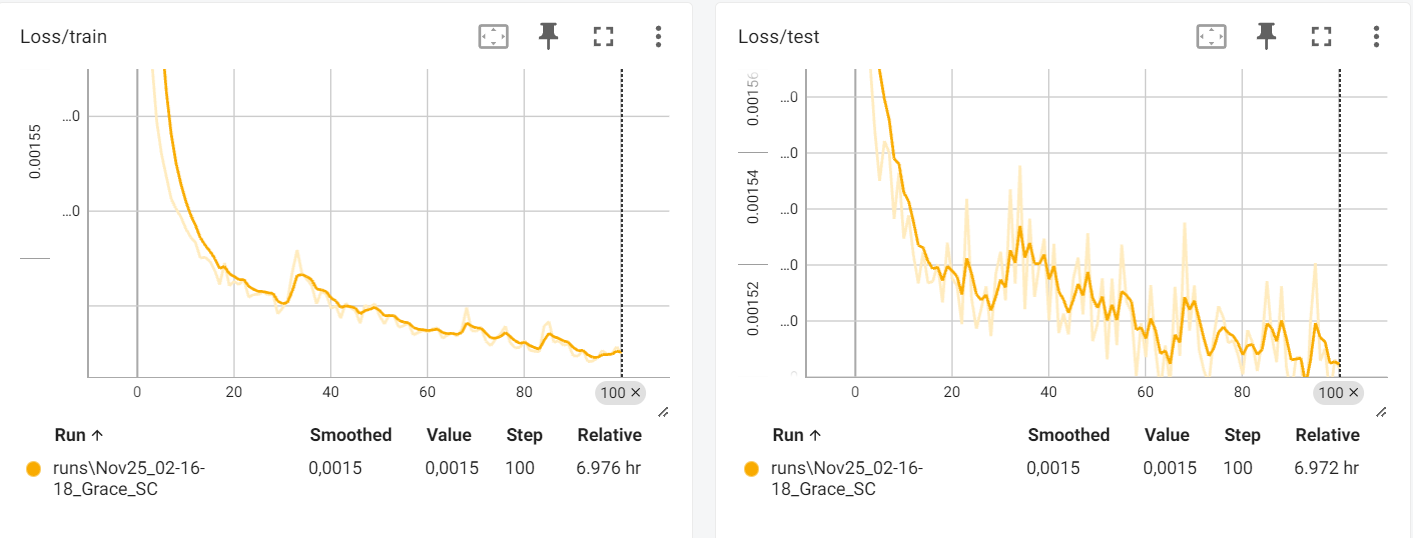

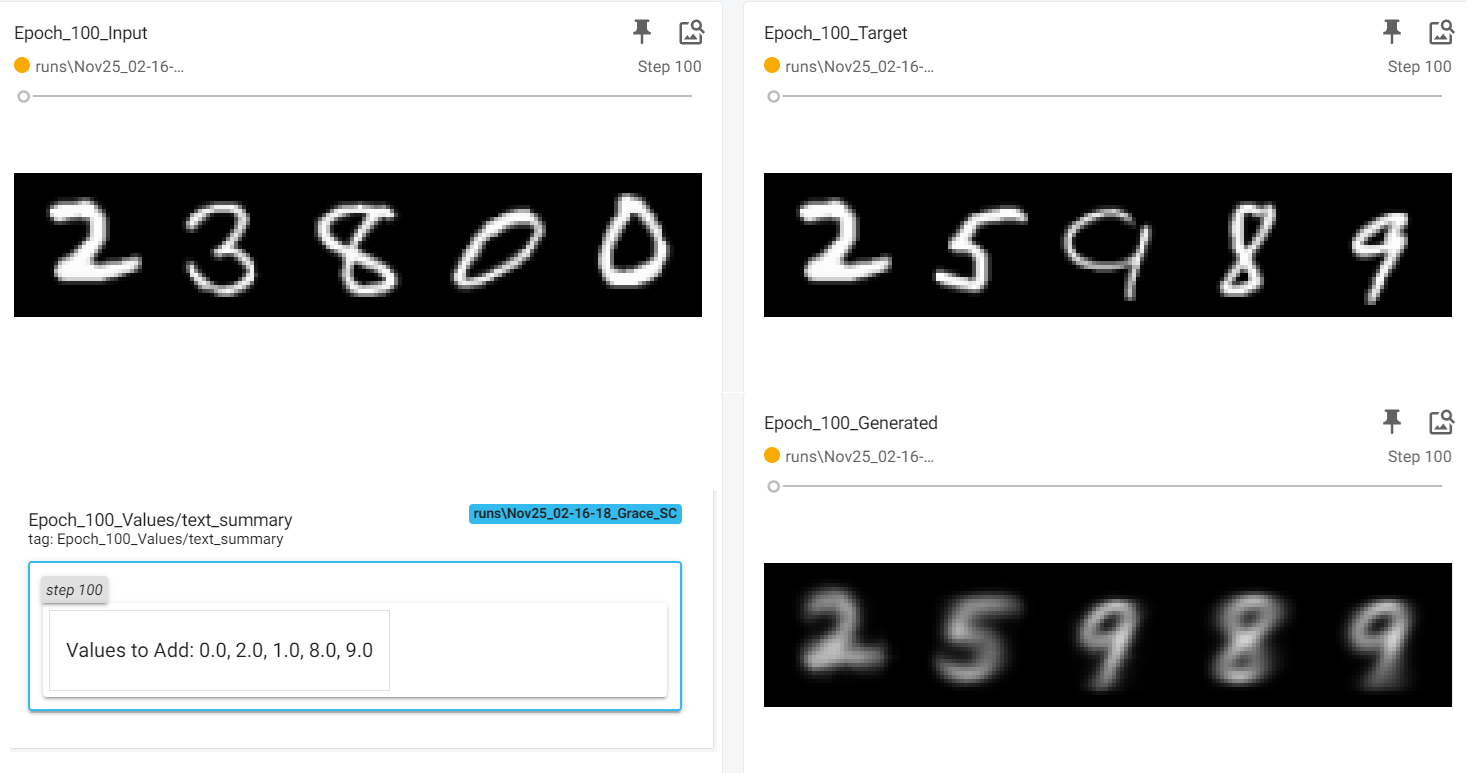

In [292]:
load_path = r'C:\Users\ksevi\OneDrive\Desktop\MASTER\THIRD SEMESTER\MACHINE LEARNING -RENATO\assignments\model_VAEgen38.pth'
model_VAE_chan=GenerativeCompleteModelVAE(encoder, adder, decoder, value_to_latent).to(device)
model_VAE_chan.load_state_dict(torch.load(load_path))
model_VAE_chan.eval()

GenerativeCompleteModelVAE(
  (encoder): VAE_Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (fc1): Linear(in_features=2048, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=50, bias=True)
    (fc_log_var): Linear(in_features=256, out_features=50, bias=True)
  )
  (adder): GenerativeAdderVAE(
    (fc1): Linear(in_features=100, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=16, bias=True)
    (fc_mu): Linear(in_features=16, out_features=50, bias=True)
    (fc_log_var): Linear(in_features=16, out_features=50, bias=True)
  )
  (decoder): DecoderConvTransposeVAE(
    (fc1): Linear(in_features=50, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=6272, b

In [293]:
def prediction_VAE_GEN(model, img_test_true, number):
    img_test_true = img_test_true.to(device)
    number_tensor = torch.tensor([number], dtype=torch.float32).to(device)

    with torch.no_grad():
        model.eval()
        _, predicted_sum_image, _, _, _, _ = model(img_test_true, number_tensor) # Cambio aquí
        return predicted_sum_image.squeeze(0).cpu().numpy()

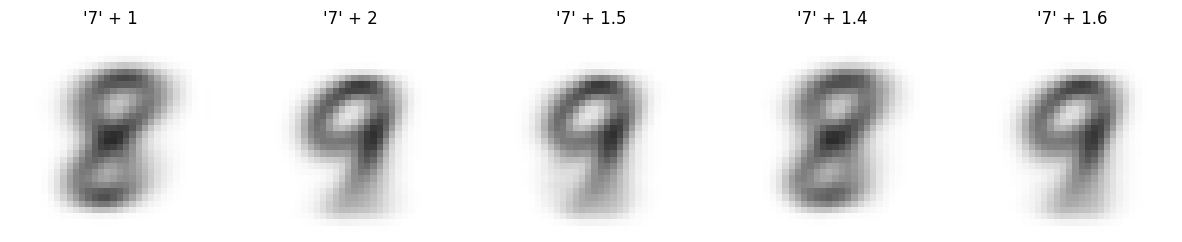

In [304]:
def visualize_model_output_GEN(model, dataloader, base_digit, additions, img_size):
    base_image = get_image_of_number(base_digit, dataloader)
    output_images = []
    
    for num in additions:
        output_image = prediction_VAE_GEN(model, base_image, num)
        output_images.append(output_image.reshape(img_size))

    fig, axes = plt.subplots(1, len(additions), figsize=(len(additions) * 3, 3))
    for i, (ax, img) in enumerate(zip(axes, output_images)):
        ax.imshow(1 - img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"'7' + {additions[i]}")
        ax.axis('off')  
    plt.show()

additions = [1, 2, 1.5, 1.4, 1.6]
img_size = (32, 32)
visualize_model_output_GEN(model_VAE_chan, train_loader_, 7, additions, img_size)

__What can you observe?__

Unlike the VAE the generative model when the decimal is equal to or greater than 0.5 the inferred image is correctly averaged to the next base number, and when it is less than 0.5 the inferred image is averaged to the previous base number correctly.